In [ ]:
# Install latest version sklearn (0.23)
!pip install -U scikit-learn

ERROR: Operation cancelled by user


In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import time
import gc
import sys
import random
import pickle

from scipy.stats import iqr
from sklearn import preprocessing

import datetime
import logging

# Deep learning
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from IPython.display import display
# Set pandas options
pd.options.display.max_rows = 2000

In [ ]:
# Global variables 
THR_E = 100 # interaction threshold of exercises (E) for user

BATCH_SIZE = 128
EPOCHS = 120
N_TRAINING_PER_EPOCH = 100000 # Random select N samples for each epoch from train set
VAL_EVERY_N_EPOCH = 3
USER_ASCENDING = True # ascending = True: 100-60. Ascending false: 60-100
AUTO = tf.data.experimental.AUTOTUNE
COLAB = True

date = datetime.datetime.today().strftime("%d-%b")
OUTPUT_FOLDER = date + "-riiid" + "-1"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [ ]:
# Selected features
selections = ["E", "r", "et_std"]
assert((selections[0] == "E") & (selections[1]=="r"))

In [ ]:
# Choose model setting
ENC_EMB, ENC_DENSE = [0], [2] 
DEC_EMB, DEC_DENSE = [1], []

In [ ]:
if COLAB:
  FOLDER_FEATHER = "/content/drive/My Drive/kaggle-riiid/feather-files"
  FOLDER_PICKLE = "/content/drive/My Drive/kaggle-riiid/sequences-dict-pickle"
  MODEL_FILE = "/content/drive/My\ Drive/Colab\ Notebooks/riiid-functional-transformer.ipynb" # https://stackoverflow.com/questions/57464810/how-to-run-a-jupyter-notebook-with-space-in-relative-path-from-another-notebook
  PREPROCESS_FILE = "/content/drive/My\ Drive/Colab\ Notebooks/riiid-preprocessing.ipynb"
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
else:
  FOLDER_FEATHER = "../input/riiid-feather-files/"

In [ ]:
# Add functions to preprocess data
%run $PREPROCESS_FILE

In [ ]:
# Create logger
logging = create_logging(OUTPUT_FOLDER)

In [ ]:
%%time
# Read all dataframes from feather files and print out
train = read_df_print(os.path.join(FOLDER_FEATHER, "train.feather")) 
questions = read_df_print(os.path.join(FOLDER_FEATHER, "questions.feather"))
lectures = read_df_print(os.path.join(FOLDER_FEATHER, "lectures.feather"))

In [ ]:
# We don't need the lectures for now!
train = train.loc[train["content_type_id"]==0]

In [ ]:
# Save space by deleting some columns
del train["row_id"], train["user_answer"], train["prior_question_had_explanation"]

In [ ]:
N_questions, N_parts = questions["question_id"].nunique(), questions["part"].nunique()
N_response, N_task = 2, 2

In [ ]:
%%time 
# Split users into multiple parts based on THR_E
train = split_into_more_users(train, ascending=USER_ASCENDING)
print(f"Number of new_user_ids: {train.new_user_id.nunique()}")

## Add all inputs/outputs

In [ ]:
# Add exercises
%time E_lists = return_E()

CPU times: user 43.8 s, sys: 1.56 s, total: 45.4 s
Wall time: 45.4 s


In [ ]:
# Add results, with start token
%time r_lists = return_r(add_start_token=True)

# delete to make space
del train["answered_correctly"]

CPU times: user 47.3 s, sys: 480 ms, total: 47.7 s
Wall time: 47.7 s


In [ ]:
p_lists, lt_lists, et_lists, tag_lists, task_lists, quantile_transformer_et = [], [], [], [], [], []

In [ ]:
if "lt" in selections:
    %time lt_lists = return_lt()

In [ ]:
if "et" in selections:
    %time et_lists = return_et()

In [ ]:
if "et_std" in selections:
    %time et_lists, quantile_transformer_et = return_et_std()

CPU times: user 1min 25s, sys: 3.15 s, total: 1min 28s
Wall time: 1min 27s


In [ ]:
if "p" in selections:
    %time p_lists = return_p()

In [ ]:
if "tag" in selections:
    %time tag_lists = return_N_highest_tags() # TODO: specify N tags

In [ ]:
if "task" in selections:
    %time task_lists = return_task_binary()

In [ ]:
feature_mapping = {"E": E_lists, "r": r_lists, "p": p_lists, "et": et_lists, "lt": lt_lists, "tag": tag_lists, "task": task_lists, "et_std": et_lists}
type_mapping = {"E": tf.float32, "r": tf.float32, "p": tf.float32, "et": tf.float32, "et_std": tf.float32, "lt": tf.float32, "tag": tf.float32, "task": tf.float32}
pad_mapping = {"E": float(N_questions), "r": float(N_response), "p": 0.0, "et": 0.0, "et_std": 0.0, "lt": 0.0, "tag": 2.0, "task": float(N_task)}
vocab_mapping = {"E": float(N_questions+1), "r": float(N_response+2), "p": float(N_parts+1), "lt": 0.0, "tag": 3.0, "task": float(N_task+1), "et": float(300), "et_std": float(300)}
pad_shapes = {"E": [THR_E], "r": [THR_E+1], "p": [THR_E], "et": [THR_E], "et_std": [THR_E],  "lt": [THR_E], "tag": [THR_E], "task": [THR_E]}

In [ ]:
vocab_sizes = [vocab_mapping[select] for select in selections]
feature_lists = [feature_mapping[select] for select in selections]

In [ ]:
PADDING_VALUES = tuple((pad_mapping[select] for select in selections))
OUTPUT_TYPES = tuple((type_mapping[select] for select in selections))
PADDED_SHAPES = tuple((pad_shapes[select] for select in selections))

In [ ]:
feature_lists

[new_user_id
 0          [5692, 5716, 128, 7860, 7922, 156, 51, 50, 789...
 1          [7900, 7876, 175, 1278, 2064, 2063, 2065, 3364...
 2          [5273, 758, 5976, 236, 404, 382, 405, 873, 531...
 3          [5000, 3944, 217, 5844, 5965, 4990, 5235, 6050...
 4          [3633, 8962, 4103, 6078, 5673, 8841, 5442, 466...
                                  ...                        
 1231587    [4137, 1270, 9261, 8201, 367, 378, 214, 6071, ...
 1231588    [3748, 4765, 5474, 9261, 4665, 5987, 6666, 561...
 1231589    [198, 899, 344, 435, 356, 5611, 11267, 4074, 3...
 1231590    [491, 659, 1195, 375, 211, 5711, 9058, 3756, 4...
 1231591    [6147, 4792, 5738, 6102, 4748, 7956, 6435, 928...
 Name: content_id, Length: 1231592, dtype: object, new_user_id
 0          [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ...
 1          [3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...
 2          [3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...
 3          [3, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1

In [ ]:
# Check if et works!
# feature_lists[2][0][:10]
# quantile_transformer_et.transform(train["prior_question_elapsed_time"].head(10).fillna(0).values.reshape(-1, 1))

In [ ]:
try:
  del train
except Exception as e:
  print("train already deleted")
gc.collect(), gc.collect()

(221, 0)

# Create train/val datasets

In [ ]:
# Creating a custom train/validation set. TODO: some shuffle before selection
train_len = int(len(r_lists)*0.9)

train_list = [features.values[:train_len] for features in feature_lists]
val_list = [features.values[train_len:] for features in feature_lists]

In [ ]:
def create_train_dataset(N_training_per_epoch):
  index = np.random.choice(train_len, N_training_per_epoch, replace=False) # random indexing (similar to shuffling)
  tr_list = [features[index] for features in train_list]
  train_dataset = (tf.data.Dataset
                  .from_generator(lambda: iter(zip(*tr_list)), output_types= OUTPUT_TYPES)
                  .padded_batch(batch_size = BATCH_SIZE, padded_shapes = PADDED_SHAPES, padding_values = PADDING_VALUES)
                  .cache()
                  .prefetch(AUTO)
  )
  return train_dataset
  
def create_val_dataset():
  val_dataset = (tf.data.Dataset
                  .from_generator(lambda: iter(zip(*val_list)), output_types=OUTPUT_TYPES)
                  .padded_batch(batch_size = BATCH_SIZE, padded_shapes = PADDED_SHAPES, padding_values = PADDING_VALUES)
                  .cache()
                  .prefetch(AUTO)
  )
  return val_dataset

## Get model and set hyperparameters

In [ ]:
if COLAB:
  %run $MODEL_FILE

In [ ]:
shutil.copy('/content/drive/My Drive/Colab Notebooks/riiid-functional-transformer.ipynb', OUTPUT_FOLDER)

'27-Nov-riiid-1/riiid-functional-transformer.ipynb'

In [ ]:
# Hyperparameters main model
config = {"features": selections, "n_features": len(selections), "vocab_sizes": vocab_sizes, 
          "enc_emb": ENC_EMB, "enc_dense": ENC_DENSE, "dec_emb": DEC_EMB, "dec_dense": DEC_DENSE, 
          "window_size": THR_E, "enc_num_layers": 2, "dec_num_layers": 2, "d_model": 256, 
          "dff": 512, "num_heads": 8, "dropout_rate": 0.1, 
          "padding_values": PADDING_VALUES, "output_types": OUTPUT_TYPES, 
          "padded_shapes": PADDED_SHAPES, "quantile_transformer_et": quantile_transformer_et, }

with open(os.path.join(OUTPUT_FOLDER, "config.pickle"), 'wb') as handle:
  pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

logging.info('config: %s', config)

27-11 15:22 root         INFO     config: {'features': ['E', 'r', 'et_std'], 'n_features': 3, 'vocab_sizes': [13524.0, 4.0, 300.0], 'enc_emb': [0], 'enc_dense': [2], 'dec_emb': [1], 'dec_dense': [], 'window_size': 100, 'enc_num_layers': 2, 'dec_num_layers': 2, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'padding_values': (13523.0, 2.0, 0.0), 'output_types': (tf.float32, tf.float32, tf.float32), 'padded_shapes': ([100], [101], [100]), 'quantile_transformer_et': QuantileTransformer(random_state=0)}


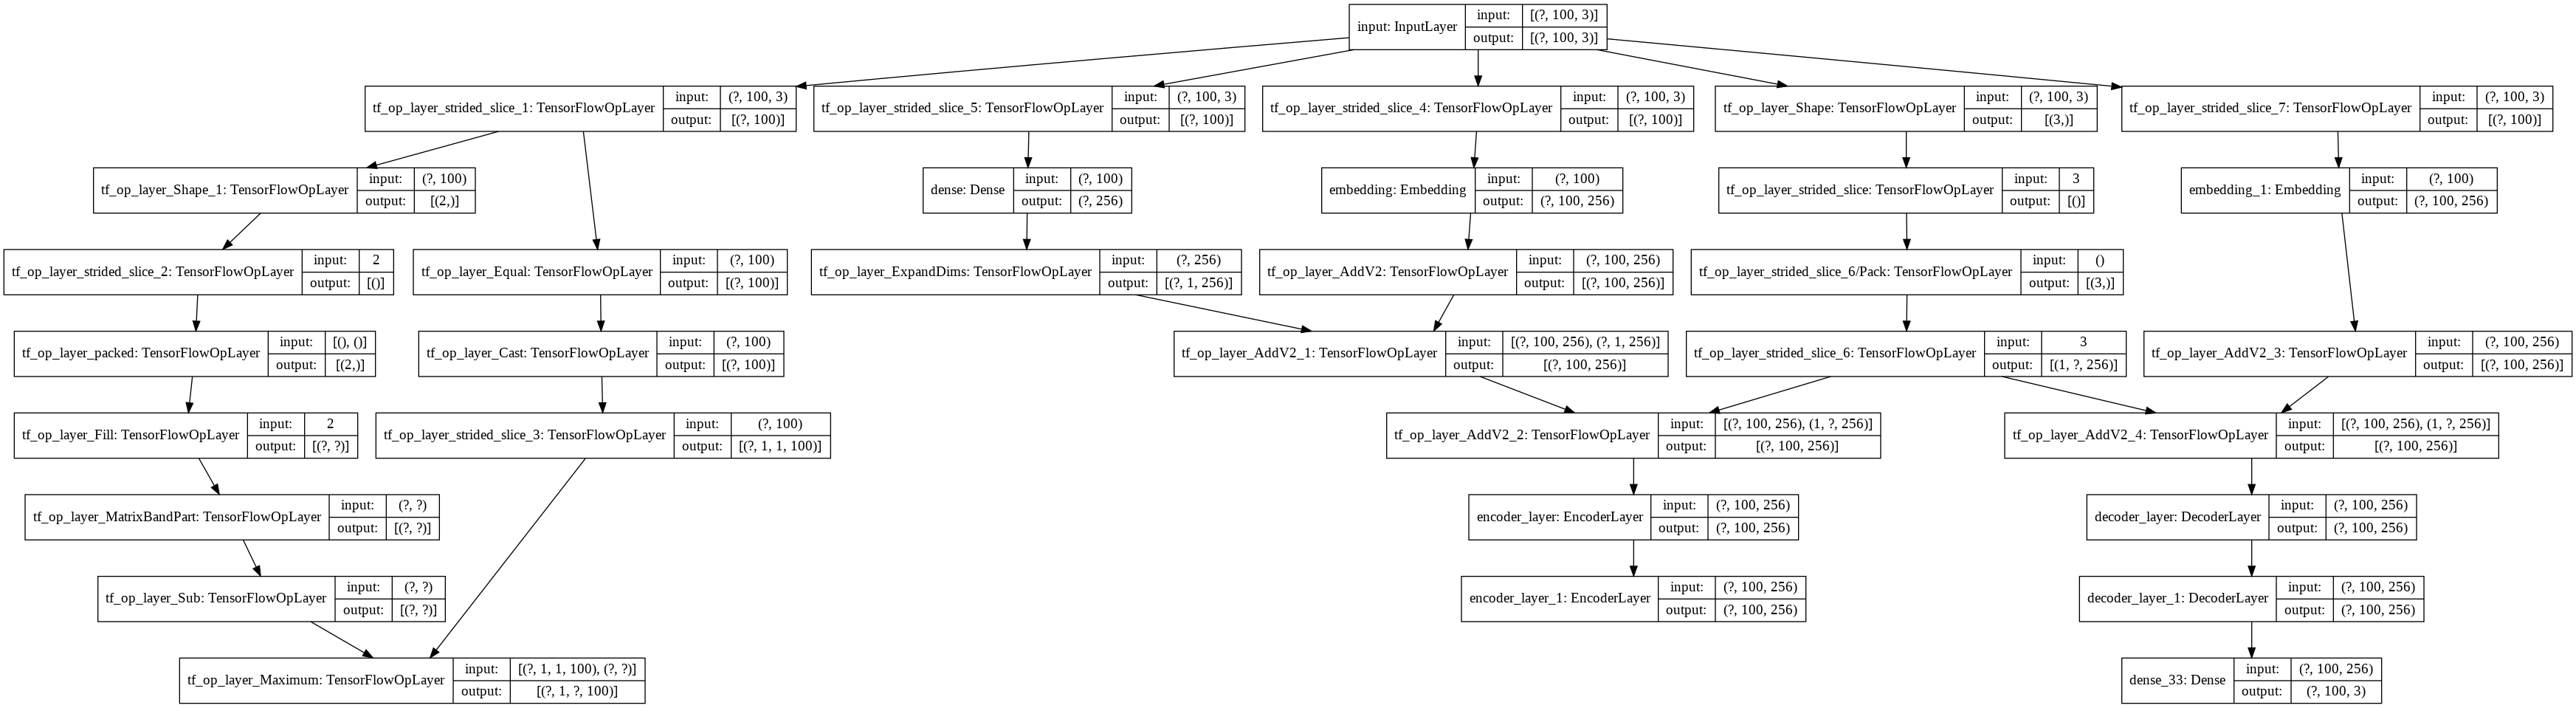

In [ ]:
transformer = create_model(config)
tf.keras.utils.plot_model(transformer, os.path.join(OUTPUT_FOLDER, "model_plot.png"), show_shapes=True)

## Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000, restart=False):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    self.restart = restart
  def __call__(self, step):
    if self.restart:
        step = step % (N_TRAINING_PER_EPOCH*2)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(config["d_model"])
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.999, 
                                      epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
# Loss and metric
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

accuracy_object = tf.keras.metrics.sparse_categorical_accuracy

train_auc= tf.keras.metrics.AUC()
val_auc= tf.keras.metrics.AUC()

In [ ]:
def loss_function(real, pred): # batch_size x seq_size x 1 vs  batch_size x seq_size x 3
    mask = tf.math.logical_not(tf.math.equal(tf.squeeze(real), N_response)) # batch_size x seq_size
    loss_ = loss_object(real, pred) # batch_size x seq_size
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask 
    loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) #loss becomes one value! (from all batches)
    return loss_

In [ ]:
def metric_function(real, pred, auc_object): # batch_size x seq_size x 1 vs  batch_size x seq_size x 3
    # Predict accuracy
    mask = tf.math.logical_not(tf.math.equal(tf.squeeze(real), N_response)) # batch_size x seq_size
    accuracy = accuracy_object(real, pred) # batch_size x seq_size
    mask = tf.cast(mask, dtype=accuracy.dtype)
    
    accuracy *= mask
    accuracy = 100*tf.reduce_sum(accuracy)/tf.reduce_sum(mask)
    
    # A work-around to predict AUC => is it stable?
    pred = tf.nn.softmax(pred)
    pred = pred[:,:,1] # pred that answer is correct
    real = tf.keras.backend.flatten(real)
    pred = tf.keras.backend.flatten(pred)
    
    idxs = tf.math.logical_not(tf.math.equal(real, N_response))
    real = real[idxs]
    pred = pred[idxs]
    auc = auc_object(real, pred)
    return accuracy

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

## Training and checkpointing

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = os.path.join(OUTPUT_FOLDER, "checkpoints/")
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# https://stackoverflow.com/questions/62919208/how-to-restore-a-specific-checkpoint-in-tensorflow2-to-implement-early-stopping

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [ ]:
@tf.function()
def train_step(inputs, tar_real):
    with tf.GradientTape() as tape: 
        predictions = transformer(inputs, training=True)
        tar_real = tf.expand_dims(tar_real, -1) # IMPORTANT! DOESN'T WORK WITHOUT IT. ALWAYS GIVES ERROR INCOMPATIBLE SHAPE. E.G. (32,169) vs. (32,169,3)
        
        loss = loss_function(tar_real, predictions)
        accuracy = metric_function(tar_real, predictions, auc_object = train_auc)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy)

@tf.function()
def val_step(inputs, tar_real):
    predictions = transformer(inputs, training=False)
    tar_real = tf.expand_dims(tar_real, -1) # IMPORTANT! DOESN'T WORK WITHOUT IT. ALWAYS GIVES ERROR INCOMPATIBLE SHAPE. E.G. (32,169) vs. (32,169,3)
    
    loss = loss_function(tar_real, predictions)
    accuracy = metric_function(tar_real, predictions, auc_object = val_auc)

    val_loss(loss)
    val_accuracy(accuracy)

In [ ]:
best_auc = 0
val_dataset = create_val_dataset() # Create val dataset = always the same for each epoch
for epoch in range(EPOCHS):
    train_dataset = create_train_dataset(N_training_per_epoch= N_TRAINING_PER_EPOCH) 
    
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    train_auc.reset_states()
    
    val_loss.reset_states()
    val_accuracy.reset_states()
    val_auc.reset_states()

    # Train
    for (batch, (features)) in enumerate(train_dataset):
        E, tar, rest = features[0], features[1], features[2:] 
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        inputs = [E, tar_inp] + list(rest)
        inputs = tf.transpose(tf.stack(inputs), perm=[1,2,0])
        
        train_step(inputs, tar_real)
        
        if batch % 50 == 0:
            print ('Epoch {} TRAIN Batch {} Loss {:.4f} Accuracy {:.4f} AUC {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result(), train_auc.result()))

    logging.info('Epoch TRAIN {} Loss {:.4f} Accuracy {:.4f} AUC {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                train_auc.result()
                                                ))
    
    # Validate and save model
    if (epoch + 1) % VAL_EVERY_N_EPOCH == 0: 
      for (batch, (features)) in enumerate(val_dataset):
          E, tar, rest = features[0], features[1], features[2:] 
          tar_inp = tar[:, :-1]
          tar_real = tar[:, 1:]

          inputs = [E, tar_inp] + list(rest)
          inputs = tf.transpose(tf.stack(inputs), perm=[1,2,0])
          
          val_step(inputs, tar_real)

          if batch % 50 == 0:
              print ('Epoch {} VAL Batch {} Loss {:.4f} Accuracy {:.4f} AUC {:.4f}'.format(
                epoch + 1, batch, val_loss.result(), val_accuracy.result(), val_auc.result()))
      
      logging.info('Epoch VAL {} Loss {:.4f} Accuracy {:.4f} AUC {:.4f}'.format(epoch + 1, 
                                          val_loss.result(), 
                                          val_accuracy.result(),
                                          val_auc.result()
                                          ))    
       
      if val_auc.result() > best_auc:
          best_auc = val_auc.result()
          ckpt_save_path = ckpt_manager.save()
          logging.info('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))
        
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 TRAIN Batch 0 Loss 1.7836 Accuracy 26.5024 AUC 0.5032
Epoch 1 TRAIN Batch 50 Loss 1.0723 Accuracy 48.6487 AUC 0.5026
Epoch 1 TRAIN Batch 100 Loss 0.8999 Accuracy 54.2087 AUC 0.5033
Epoch 1 TRAIN Batch 150 Loss 0.8325 Accuracy 56.4687 AUC 0.5056
Epoch 1 TRAIN Batch 200 Loss 0.7937 Accuracy 57.9946 AUC 0.5081
Epoch 1 TRAIN Batch 250 Loss 0.7679 Accuracy 59.1048 AUC 0.5113
Epoch 1 TRAIN Batch 300 Loss 0.7491 Accuracy 60.0178 AUC 0.5140
Epoch 1 TRAIN Batch 350 Loss 0.7351 Accuracy 60.7276 AUC 0.5163
Epoch 1 TRAIN Batch 400 Loss 0.7238 Accuracy 61.3473 AUC 0.5188
Epoch 1 TRAIN Batch 450 Loss 0.7151 Accuracy 61.7990 AUC 0.5210
Epoch 1 TRAIN Batch 500 Loss 0.7075 Accuracy 62.2419 AUC 0.5232
Epoch 1 TRAIN Batch 550 Loss 0.7013 Accuracy 62.5892 AUC 0.5256
Epoch 1 TRAIN Batch 600 Loss 0.6959 Accuracy 62.8857 AUC 0.5288
Epoch 1 TRAIN Batch 650 Loss 0.6908 Accuracy 63.1732 AUC 0.5328
Epoch 1 TRAIN Batch 700 Loss 0.6862 Accuracy 63.4183 AUC 0.5376
Epoch 1 TRAIN Batch 750 Loss 0.6821 Accurac

27-11 15:23 root         INFO     Epoch TRAIN 1 Loss 0.6798 Accuracy 63.7565 AUC 0.5451


Time taken for 1 epoch: 69.22840094566345 secs

Epoch 2 TRAIN Batch 0 Loss 0.6327 Accuracy 65.1992 AUC 0.6260
Epoch 2 TRAIN Batch 50 Loss 0.6202 Accuracy 67.1553 AUC 0.6189
Epoch 2 TRAIN Batch 100 Loss 0.6206 Accuracy 67.0597 AUC 0.6193
Epoch 2 TRAIN Batch 150 Loss 0.6204 Accuracy 67.0348 AUC 0.6206
Epoch 2 TRAIN Batch 200 Loss 0.6203 Accuracy 67.0227 AUC 0.6216
Epoch 2 TRAIN Batch 250 Loss 0.6199 Accuracy 67.0641 AUC 0.6225
Epoch 2 TRAIN Batch 300 Loss 0.6197 Accuracy 67.0683 AUC 0.6232
Epoch 2 TRAIN Batch 350 Loss 0.6200 Accuracy 67.0469 AUC 0.6227
Epoch 2 TRAIN Batch 400 Loss 0.6198 Accuracy 67.0629 AUC 0.6232
Epoch 2 TRAIN Batch 450 Loss 0.6195 Accuracy 67.0938 AUC 0.6236
Epoch 2 TRAIN Batch 500 Loss 0.6192 Accuracy 67.1157 AUC 0.6241
Epoch 2 TRAIN Batch 550 Loss 0.6191 Accuracy 67.1293 AUC 0.6244
Epoch 2 TRAIN Batch 600 Loss 0.6189 Accuracy 67.1420 AUC 0.6248
Epoch 2 TRAIN Batch 650 Loss 0.6187 Accuracy 67.1536 AUC 0.6253
Epoch 2 TRAIN Batch 700 Loss 0.6186 Accuracy 67.1564 AUC 0.

27-11 15:24 root         INFO     Epoch TRAIN 2 Loss 0.6184 Accuracy 67.1621 AUC 0.6262


Time taken for 1 epoch: 60.85111355781555 secs

Epoch 3 TRAIN Batch 0 Loss 0.6172 Accuracy 67.5714 AUC 0.6276
Epoch 3 TRAIN Batch 50 Loss 0.6156 Accuracy 67.4098 AUC 0.6337
Epoch 3 TRAIN Batch 100 Loss 0.6163 Accuracy 67.3006 AUC 0.6335
Epoch 3 TRAIN Batch 150 Loss 0.6161 Accuracy 67.3197 AUC 0.6332
Epoch 3 TRAIN Batch 200 Loss 0.6154 Accuracy 67.4034 AUC 0.6333
Epoch 3 TRAIN Batch 250 Loss 0.6152 Accuracy 67.4303 AUC 0.6337
Epoch 3 TRAIN Batch 300 Loss 0.6151 Accuracy 67.4451 AUC 0.6336
Epoch 3 TRAIN Batch 350 Loss 0.6148 Accuracy 67.4833 AUC 0.6339
Epoch 3 TRAIN Batch 400 Loss 0.6148 Accuracy 67.4925 AUC 0.6341
Epoch 3 TRAIN Batch 450 Loss 0.6146 Accuracy 67.5172 AUC 0.6346
Epoch 3 TRAIN Batch 500 Loss 0.6142 Accuracy 67.5446 AUC 0.6357
Epoch 3 TRAIN Batch 550 Loss 0.6130 Accuracy 67.6322 AUC 0.6384
Epoch 3 TRAIN Batch 600 Loss 0.6107 Accuracy 67.7777 AUC 0.6438
Epoch 3 TRAIN Batch 650 Loss 0.6076 Accuracy 67.9969 AUC 0.6507
Epoch 3 TRAIN Batch 700 Loss 0.6045 Accuracy 68.2053 AUC 0.

27-11 15:25 root         INFO     Epoch TRAIN 3 Loss 0.5998 Accuracy 68.5257 AUC 0.6668


Epoch 3 VAL Batch 0 Loss 0.5129 Accuracy 74.4136 AUC 0.7723
Epoch 3 VAL Batch 50 Loss 0.5563 Accuracy 71.4841 AUC 0.7469
Epoch 3 VAL Batch 100 Loss 0.5536 Accuracy 71.6581 AUC 0.7491
Epoch 3 VAL Batch 150 Loss 0.5536 Accuracy 71.6351 AUC 0.7493
Epoch 3 VAL Batch 200 Loss 0.5517 Accuracy 71.7586 AUC 0.7501
Epoch 3 VAL Batch 250 Loss 0.5524 Accuracy 71.6785 AUC 0.7496
Epoch 3 VAL Batch 300 Loss 0.5528 Accuracy 71.6373 AUC 0.7490
Epoch 3 VAL Batch 350 Loss 0.5538 Accuracy 71.5545 AUC 0.7493
Epoch 3 VAL Batch 400 Loss 0.5530 Accuracy 71.6224 AUC 0.7493
Epoch 3 VAL Batch 450 Loss 0.5531 Accuracy 71.6125 AUC 0.7494
Epoch 3 VAL Batch 500 Loss 0.5543 Accuracy 71.5135 AUC 0.7489
Epoch 3 VAL Batch 550 Loss 0.5538 Accuracy 71.5499 AUC 0.7490
Epoch 3 VAL Batch 600 Loss 0.5532 Accuracy 71.5873 AUC 0.7491
Epoch 3 VAL Batch 650 Loss 0.5530 Accuracy 71.5983 AUC 0.7492
Epoch 3 VAL Batch 700 Loss 0.5525 Accuracy 71.6447 AUC 0.7494
Epoch 3 VAL Batch 750 Loss 0.5525 Accuracy 71.6458 AUC 0.7494
Epoch 3 VAL

27-11 15:26 root         INFO     Epoch VAL 3 Loss 0.5521 Accuracy 71.6759 AUC 0.7494
27-11 15:26 root         INFO     Saving checkpoint for epoch 3 at 27-Nov-riiid-1/checkpoints/ckpt-1


Time taken for 1 epoch: 88.49202609062195 secs

Epoch 4 TRAIN Batch 0 Loss 0.5597 Accuracy 70.9366 AUC 0.7457
Epoch 4 TRAIN Batch 50 Loss 0.5567 Accuracy 71.4313 AUC 0.7407
Epoch 4 TRAIN Batch 100 Loss 0.5576 Accuracy 71.3035 AUC 0.7404
Epoch 4 TRAIN Batch 150 Loss 0.5568 Accuracy 71.3517 AUC 0.7415
Epoch 4 TRAIN Batch 200 Loss 0.5562 Accuracy 71.3894 AUC 0.7423
Epoch 4 TRAIN Batch 250 Loss 0.5556 Accuracy 71.4375 AUC 0.7431
Epoch 4 TRAIN Batch 300 Loss 0.5550 Accuracy 71.4715 AUC 0.7441
Epoch 4 TRAIN Batch 350 Loss 0.5547 Accuracy 71.4893 AUC 0.7444
Epoch 4 TRAIN Batch 400 Loss 0.5544 Accuracy 71.5020 AUC 0.7446
Epoch 4 TRAIN Batch 450 Loss 0.5542 Accuracy 71.5162 AUC 0.7450
Epoch 4 TRAIN Batch 500 Loss 0.5541 Accuracy 71.5207 AUC 0.7452
Epoch 4 TRAIN Batch 550 Loss 0.5538 Accuracy 71.5371 AUC 0.7456
Epoch 4 TRAIN Batch 600 Loss 0.5535 Accuracy 71.5635 AUC 0.7458
Epoch 4 TRAIN Batch 650 Loss 0.5532 Accuracy 71.5776 AUC 0.7462
Epoch 4 TRAIN Batch 700 Loss 0.5529 Accuracy 71.5908 AUC 0.

27-11 15:27 root         INFO     Epoch TRAIN 4 Loss 0.5527 Accuracy 71.6020 AUC 0.7469


Time taken for 1 epoch: 59.259408950805664 secs

Epoch 5 TRAIN Batch 0 Loss 0.5565 Accuracy 71.2999 AUC 0.7326
Epoch 5 TRAIN Batch 50 Loss 0.5489 Accuracy 71.8864 AUC 0.7513
Epoch 5 TRAIN Batch 100 Loss 0.5502 Accuracy 71.7498 AUC 0.7500
Epoch 5 TRAIN Batch 150 Loss 0.5494 Accuracy 71.8406 AUC 0.7500
Epoch 5 TRAIN Batch 200 Loss 0.5498 Accuracy 71.8017 AUC 0.7499
Epoch 5 TRAIN Batch 250 Loss 0.5497 Accuracy 71.8068 AUC 0.7503
Epoch 5 TRAIN Batch 300 Loss 0.5494 Accuracy 71.8238 AUC 0.7504
Epoch 5 TRAIN Batch 350 Loss 0.5495 Accuracy 71.8047 AUC 0.7506
Epoch 5 TRAIN Batch 400 Loss 0.5493 Accuracy 71.8216 AUC 0.7508
Epoch 5 TRAIN Batch 450 Loss 0.5494 Accuracy 71.8156 AUC 0.7507
Epoch 5 TRAIN Batch 500 Loss 0.5496 Accuracy 71.7980 AUC 0.7505
Epoch 5 TRAIN Batch 550 Loss 0.5496 Accuracy 71.8069 AUC 0.7506
Epoch 5 TRAIN Batch 600 Loss 0.5493 Accuracy 71.8320 AUC 0.7507
Epoch 5 TRAIN Batch 650 Loss 0.5493 Accuracy 71.8322 AUC 0.7507
Epoch 5 TRAIN Batch 700 Loss 0.5492 Accuracy 71.8420 AUC 0

27-11 15:28 root         INFO     Epoch TRAIN 5 Loss 0.5491 Accuracy 71.8485 AUC 0.7510


Time taken for 1 epoch: 60.09596490859985 secs

Epoch 6 TRAIN Batch 0 Loss 0.5539 Accuracy 71.9646 AUC 0.7555
Epoch 6 TRAIN Batch 50 Loss 0.5468 Accuracy 71.9880 AUC 0.7515
Epoch 6 TRAIN Batch 100 Loss 0.5477 Accuracy 71.9435 AUC 0.7511
Epoch 6 TRAIN Batch 150 Loss 0.5475 Accuracy 71.9647 AUC 0.7514
Epoch 6 TRAIN Batch 200 Loss 0.5475 Accuracy 71.9596 AUC 0.7520
Epoch 6 TRAIN Batch 250 Loss 0.5475 Accuracy 71.9498 AUC 0.7520
Epoch 6 TRAIN Batch 300 Loss 0.5474 Accuracy 71.9526 AUC 0.7524
Epoch 6 TRAIN Batch 350 Loss 0.5472 Accuracy 71.9611 AUC 0.7528
Epoch 6 TRAIN Batch 400 Loss 0.5472 Accuracy 71.9581 AUC 0.7528
Epoch 6 TRAIN Batch 450 Loss 0.5475 Accuracy 71.9346 AUC 0.7524
Epoch 6 TRAIN Batch 500 Loss 0.5476 Accuracy 71.9299 AUC 0.7523
Epoch 6 TRAIN Batch 550 Loss 0.5475 Accuracy 71.9348 AUC 0.7523
Epoch 6 TRAIN Batch 600 Loss 0.5478 Accuracy 71.9100 AUC 0.7523
Epoch 6 TRAIN Batch 650 Loss 0.5479 Accuracy 71.8973 AUC 0.7522
Epoch 6 TRAIN Batch 700 Loss 0.5476 Accuracy 71.9183 AUC 0.

27-11 15:29 root         INFO     Epoch TRAIN 6 Loss 0.5475 Accuracy 71.9287 AUC 0.7527


Epoch 6 VAL Batch 0 Loss 0.5072 Accuracy 74.5637 AUC 0.7791
Epoch 6 VAL Batch 50 Loss 0.5525 Accuracy 71.6583 AUC 0.7519
Epoch 6 VAL Batch 100 Loss 0.5493 Accuracy 71.8406 AUC 0.7544
Epoch 6 VAL Batch 150 Loss 0.5494 Accuracy 71.8278 AUC 0.7547
Epoch 6 VAL Batch 200 Loss 0.5475 Accuracy 71.9597 AUC 0.7554
Epoch 6 VAL Batch 250 Loss 0.5481 Accuracy 71.8922 AUC 0.7550
Epoch 6 VAL Batch 300 Loss 0.5486 Accuracy 71.8565 AUC 0.7544
Epoch 6 VAL Batch 350 Loss 0.5495 Accuracy 71.7789 AUC 0.7547
Epoch 6 VAL Batch 400 Loss 0.5487 Accuracy 71.8469 AUC 0.7548
Epoch 6 VAL Batch 450 Loss 0.5488 Accuracy 71.8448 AUC 0.7549
Epoch 6 VAL Batch 500 Loss 0.5500 Accuracy 71.7462 AUC 0.7544
Epoch 6 VAL Batch 550 Loss 0.5495 Accuracy 71.7836 AUC 0.7544
Epoch 6 VAL Batch 600 Loss 0.5489 Accuracy 71.8210 AUC 0.7545
Epoch 6 VAL Batch 650 Loss 0.5487 Accuracy 71.8335 AUC 0.7547
Epoch 6 VAL Batch 700 Loss 0.5482 Accuracy 71.8756 AUC 0.7549
Epoch 6 VAL Batch 750 Loss 0.5482 Accuracy 71.8778 AUC 0.7549
Epoch 6 VAL

27-11 15:29 root         INFO     Epoch VAL 6 Loss 0.5478 Accuracy 71.9101 AUC 0.7549
27-11 15:29 root         INFO     Saving checkpoint for epoch 6 at 27-Nov-riiid-1/checkpoints/ckpt-2


Time taken for 1 epoch: 82.20328378677368 secs

Epoch 7 TRAIN Batch 0 Loss 0.5561 Accuracy 70.8861 AUC 0.7422
Epoch 7 TRAIN Batch 50 Loss 0.5454 Accuracy 72.0957 AUC 0.7537
Epoch 7 TRAIN Batch 100 Loss 0.5468 Accuracy 72.0017 AUC 0.7528
Epoch 7 TRAIN Batch 150 Loss 0.5465 Accuracy 72.0174 AUC 0.7536
Epoch 7 TRAIN Batch 200 Loss 0.5470 Accuracy 71.9748 AUC 0.7537
Epoch 7 TRAIN Batch 250 Loss 0.5470 Accuracy 71.9779 AUC 0.7534
Epoch 7 TRAIN Batch 300 Loss 0.5470 Accuracy 71.9740 AUC 0.7534
Epoch 7 TRAIN Batch 350 Loss 0.5471 Accuracy 71.9623 AUC 0.7532
Epoch 7 TRAIN Batch 400 Loss 0.5470 Accuracy 71.9717 AUC 0.7531
Epoch 7 TRAIN Batch 450 Loss 0.5468 Accuracy 71.9874 AUC 0.7533
Epoch 7 TRAIN Batch 500 Loss 0.5468 Accuracy 71.9857 AUC 0.7535
Epoch 7 TRAIN Batch 550 Loss 0.5467 Accuracy 71.9932 AUC 0.7537
Epoch 7 TRAIN Batch 600 Loss 0.5468 Accuracy 71.9796 AUC 0.7536
Epoch 7 TRAIN Batch 650 Loss 0.5469 Accuracy 71.9757 AUC 0.7536
Epoch 7 TRAIN Batch 700 Loss 0.5468 Accuracy 71.9842 AUC 0.

27-11 15:30 root         INFO     Epoch TRAIN 7 Loss 0.5468 Accuracy 71.9808 AUC 0.7538


Time taken for 1 epoch: 60.27565312385559 secs

Epoch 8 TRAIN Batch 0 Loss 0.5503 Accuracy 71.5689 AUC 0.7442
Epoch 8 TRAIN Batch 50 Loss 0.5476 Accuracy 71.9155 AUC 0.7540
Epoch 8 TRAIN Batch 100 Loss 0.5475 Accuracy 71.9055 AUC 0.7543
Epoch 8 TRAIN Batch 150 Loss 0.5472 Accuracy 71.9360 AUC 0.7543
Epoch 8 TRAIN Batch 200 Loss 0.5465 Accuracy 71.9716 AUC 0.7548
Epoch 8 TRAIN Batch 250 Loss 0.5467 Accuracy 71.9597 AUC 0.7546
Epoch 8 TRAIN Batch 300 Loss 0.5467 Accuracy 71.9694 AUC 0.7547
Epoch 8 TRAIN Batch 350 Loss 0.5465 Accuracy 71.9953 AUC 0.7549
Epoch 8 TRAIN Batch 400 Loss 0.5462 Accuracy 72.0099 AUC 0.7551
Epoch 8 TRAIN Batch 450 Loss 0.5462 Accuracy 72.0162 AUC 0.7550
Epoch 8 TRAIN Batch 500 Loss 0.5460 Accuracy 72.0317 AUC 0.7551
Epoch 8 TRAIN Batch 550 Loss 0.5460 Accuracy 72.0365 AUC 0.7552
Epoch 8 TRAIN Batch 600 Loss 0.5458 Accuracy 72.0443 AUC 0.7554
Epoch 8 TRAIN Batch 650 Loss 0.5458 Accuracy 72.0506 AUC 0.7556
Epoch 8 TRAIN Batch 700 Loss 0.5457 Accuracy 72.0547 AUC 0.

27-11 15:31 root         INFO     Epoch TRAIN 8 Loss 0.5456 Accuracy 72.0562 AUC 0.7555


Time taken for 1 epoch: 60.227444648742676 secs

Epoch 9 TRAIN Batch 0 Loss 0.5402 Accuracy 73.0977 AUC 0.7572
Epoch 9 TRAIN Batch 50 Loss 0.5441 Accuracy 72.1953 AUC 0.7569
Epoch 9 TRAIN Batch 100 Loss 0.5448 Accuracy 72.1249 AUC 0.7562
Epoch 9 TRAIN Batch 150 Loss 0.5445 Accuracy 72.1620 AUC 0.7564
Epoch 9 TRAIN Batch 200 Loss 0.5441 Accuracy 72.1959 AUC 0.7568
Epoch 9 TRAIN Batch 250 Loss 0.5441 Accuracy 72.1875 AUC 0.7566
Epoch 9 TRAIN Batch 300 Loss 0.5441 Accuracy 72.1826 AUC 0.7568
Epoch 9 TRAIN Batch 350 Loss 0.5442 Accuracy 72.1820 AUC 0.7568
Epoch 9 TRAIN Batch 400 Loss 0.5440 Accuracy 72.1984 AUC 0.7568
Epoch 9 TRAIN Batch 450 Loss 0.5439 Accuracy 72.2064 AUC 0.7568
Epoch 9 TRAIN Batch 500 Loss 0.5442 Accuracy 72.1817 AUC 0.7567
Epoch 9 TRAIN Batch 550 Loss 0.5442 Accuracy 72.1846 AUC 0.7567
Epoch 9 TRAIN Batch 600 Loss 0.5443 Accuracy 72.1753 AUC 0.7567
Epoch 9 TRAIN Batch 650 Loss 0.5442 Accuracy 72.1791 AUC 0.7567
Epoch 9 TRAIN Batch 700 Loss 0.5441 Accuracy 72.1895 AUC 0

27-11 15:32 root         INFO     Epoch TRAIN 9 Loss 0.5442 Accuracy 72.1749 AUC 0.7568


Epoch 9 VAL Batch 0 Loss 0.5017 Accuracy 74.7420 AUC 0.7850
Epoch 9 VAL Batch 50 Loss 0.5486 Accuracy 71.9242 AUC 0.7560
Epoch 9 VAL Batch 100 Loss 0.5456 Accuracy 72.1284 AUC 0.7584
Epoch 9 VAL Batch 150 Loss 0.5456 Accuracy 72.1198 AUC 0.7586
Epoch 9 VAL Batch 200 Loss 0.5437 Accuracy 72.2477 AUC 0.7594
Epoch 9 VAL Batch 250 Loss 0.5443 Accuracy 72.1799 AUC 0.7590
Epoch 9 VAL Batch 300 Loss 0.5448 Accuracy 72.1419 AUC 0.7584
Epoch 9 VAL Batch 350 Loss 0.5456 Accuracy 72.0811 AUC 0.7587
Epoch 9 VAL Batch 400 Loss 0.5448 Accuracy 72.1438 AUC 0.7589
Epoch 9 VAL Batch 450 Loss 0.5448 Accuracy 72.1430 AUC 0.7590
Epoch 9 VAL Batch 500 Loss 0.5459 Accuracy 72.0543 AUC 0.7586
Epoch 9 VAL Batch 550 Loss 0.5455 Accuracy 72.0900 AUC 0.7586
Epoch 9 VAL Batch 600 Loss 0.5450 Accuracy 72.1275 AUC 0.7587
Epoch 9 VAL Batch 650 Loss 0.5447 Accuracy 72.1379 AUC 0.7588
Epoch 9 VAL Batch 700 Loss 0.5442 Accuracy 72.1804 AUC 0.7590
Epoch 9 VAL Batch 750 Loss 0.5442 Accuracy 72.1840 AUC 0.7590
Epoch 9 VAL

27-11 15:32 root         INFO     Epoch VAL 9 Loss 0.5437 Accuracy 72.2206 AUC 0.7591
27-11 15:32 root         INFO     Saving checkpoint for epoch 9 at 27-Nov-riiid-1/checkpoints/ckpt-3


Time taken for 1 epoch: 82.00574660301208 secs

Epoch 10 TRAIN Batch 0 Loss 0.5396 Accuracy 72.4178 AUC 0.7570
Epoch 10 TRAIN Batch 50 Loss 0.5441 Accuracy 72.1494 AUC 0.7571
Epoch 10 TRAIN Batch 100 Loss 0.5434 Accuracy 72.2269 AUC 0.7568
Epoch 10 TRAIN Batch 150 Loss 0.5435 Accuracy 72.2181 AUC 0.7568
Epoch 10 TRAIN Batch 200 Loss 0.5435 Accuracy 72.2101 AUC 0.7571
Epoch 10 TRAIN Batch 250 Loss 0.5434 Accuracy 72.2272 AUC 0.7573
Epoch 10 TRAIN Batch 300 Loss 0.5427 Accuracy 72.2802 AUC 0.7581
Epoch 10 TRAIN Batch 350 Loss 0.5425 Accuracy 72.2955 AUC 0.7582
Epoch 10 TRAIN Batch 400 Loss 0.5427 Accuracy 72.2732 AUC 0.7582
Epoch 10 TRAIN Batch 450 Loss 0.5430 Accuracy 72.2543 AUC 0.7581
Epoch 10 TRAIN Batch 500 Loss 0.5430 Accuracy 72.2500 AUC 0.7581
Epoch 10 TRAIN Batch 550 Loss 0.5427 Accuracy 72.2721 AUC 0.7582
Epoch 10 TRAIN Batch 600 Loss 0.5426 Accuracy 72.2779 AUC 0.7583
Epoch 10 TRAIN Batch 650 Loss 0.5426 Accuracy 72.2814 AUC 0.7584
Epoch 10 TRAIN Batch 700 Loss 0.5425 Accuracy

27-11 15:33 root         INFO     Epoch TRAIN 10 Loss 0.5425 Accuracy 72.2875 AUC 0.7585


Time taken for 1 epoch: 60.286785364151 secs

Epoch 11 TRAIN Batch 0 Loss 0.5402 Accuracy 72.6015 AUC 0.7593
Epoch 11 TRAIN Batch 50 Loss 0.5435 Accuracy 72.2140 AUC 0.7574
Epoch 11 TRAIN Batch 100 Loss 0.5434 Accuracy 72.2174 AUC 0.7588
Epoch 11 TRAIN Batch 150 Loss 0.5430 Accuracy 72.2530 AUC 0.7590
Epoch 11 TRAIN Batch 200 Loss 0.5422 Accuracy 72.3066 AUC 0.7594
Epoch 11 TRAIN Batch 250 Loss 0.5421 Accuracy 72.3136 AUC 0.7595
Epoch 11 TRAIN Batch 300 Loss 0.5421 Accuracy 72.3080 AUC 0.7595
Epoch 11 TRAIN Batch 350 Loss 0.5423 Accuracy 72.2942 AUC 0.7593
Epoch 11 TRAIN Batch 400 Loss 0.5425 Accuracy 72.2817 AUC 0.7592
Epoch 11 TRAIN Batch 450 Loss 0.5424 Accuracy 72.2831 AUC 0.7593
Epoch 11 TRAIN Batch 500 Loss 0.5423 Accuracy 72.2949 AUC 0.7592
Epoch 11 TRAIN Batch 550 Loss 0.5422 Accuracy 72.2981 AUC 0.7593
Epoch 11 TRAIN Batch 600 Loss 0.5422 Accuracy 72.2981 AUC 0.7593
Epoch 11 TRAIN Batch 650 Loss 0.5422 Accuracy 72.2974 AUC 0.7592
Epoch 11 TRAIN Batch 700 Loss 0.5422 Accuracy 7

27-11 15:34 root         INFO     Epoch TRAIN 11 Loss 0.5421 Accuracy 72.2968 AUC 0.7593


Time taken for 1 epoch: 60.14366817474365 secs

Epoch 12 TRAIN Batch 0 Loss 0.5322 Accuracy 73.6646 AUC 0.7633
Epoch 12 TRAIN Batch 50 Loss 0.5421 Accuracy 72.3233 AUC 0.7593
Epoch 12 TRAIN Batch 100 Loss 0.5413 Accuracy 72.3356 AUC 0.7601
Epoch 12 TRAIN Batch 150 Loss 0.5408 Accuracy 72.3725 AUC 0.7607
Epoch 12 TRAIN Batch 200 Loss 0.5411 Accuracy 72.3578 AUC 0.7607
Epoch 12 TRAIN Batch 250 Loss 0.5414 Accuracy 72.3505 AUC 0.7605
Epoch 12 TRAIN Batch 300 Loss 0.5414 Accuracy 72.3548 AUC 0.7604
Epoch 12 TRAIN Batch 350 Loss 0.5414 Accuracy 72.3561 AUC 0.7603
Epoch 12 TRAIN Batch 400 Loss 0.5413 Accuracy 72.3622 AUC 0.7603
Epoch 12 TRAIN Batch 450 Loss 0.5415 Accuracy 72.3455 AUC 0.7602
Epoch 12 TRAIN Batch 500 Loss 0.5414 Accuracy 72.3455 AUC 0.7603
Epoch 12 TRAIN Batch 550 Loss 0.5415 Accuracy 72.3425 AUC 0.7603
Epoch 12 TRAIN Batch 600 Loss 0.5413 Accuracy 72.3605 AUC 0.7604
Epoch 12 TRAIN Batch 650 Loss 0.5413 Accuracy 72.3566 AUC 0.7603
Epoch 12 TRAIN Batch 700 Loss 0.5415 Accuracy

27-11 15:35 root         INFO     Epoch TRAIN 12 Loss 0.5415 Accuracy 72.3465 AUC 0.7603


Epoch 12 VAL Batch 0 Loss 0.4992 Accuracy 74.9578 AUC 0.7875
Epoch 12 VAL Batch 50 Loss 0.5464 Accuracy 72.0917 AUC 0.7585
Epoch 12 VAL Batch 100 Loss 0.5432 Accuracy 72.2609 AUC 0.7609
Epoch 12 VAL Batch 150 Loss 0.5432 Accuracy 72.2587 AUC 0.7612
Epoch 12 VAL Batch 200 Loss 0.5413 Accuracy 72.3807 AUC 0.7620
Epoch 12 VAL Batch 250 Loss 0.5420 Accuracy 72.3062 AUC 0.7616
Epoch 12 VAL Batch 300 Loss 0.5424 Accuracy 72.2703 AUC 0.7610
Epoch 12 VAL Batch 350 Loss 0.5433 Accuracy 72.1994 AUC 0.7613
Epoch 12 VAL Batch 400 Loss 0.5425 Accuracy 72.2750 AUC 0.7614
Epoch 12 VAL Batch 450 Loss 0.5425 Accuracy 72.2777 AUC 0.7616
Epoch 12 VAL Batch 500 Loss 0.5437 Accuracy 72.1901 AUC 0.7611
Epoch 12 VAL Batch 550 Loss 0.5432 Accuracy 72.2233 AUC 0.7612
Epoch 12 VAL Batch 600 Loss 0.5427 Accuracy 72.2620 AUC 0.7612
Epoch 12 VAL Batch 650 Loss 0.5425 Accuracy 72.2758 AUC 0.7614
Epoch 12 VAL Batch 700 Loss 0.5419 Accuracy 72.3185 AUC 0.7616
Epoch 12 VAL Batch 750 Loss 0.5419 Accuracy 72.3214 AUC 0.

27-11 15:36 root         INFO     Epoch VAL 12 Loss 0.5415 Accuracy 72.3530 AUC 0.7617
27-11 15:36 root         INFO     Saving checkpoint for epoch 12 at 27-Nov-riiid-1/checkpoints/ckpt-4


Time taken for 1 epoch: 82.33872389793396 secs

Epoch 13 TRAIN Batch 0 Loss 0.5285 Accuracy 73.4700 AUC 0.7707
Epoch 13 TRAIN Batch 50 Loss 0.5396 Accuracy 72.4130 AUC 0.7616
Epoch 13 TRAIN Batch 100 Loss 0.5409 Accuracy 72.3123 AUC 0.7609
Epoch 13 TRAIN Batch 150 Loss 0.5403 Accuracy 72.3769 AUC 0.7611
Epoch 13 TRAIN Batch 200 Loss 0.5398 Accuracy 72.4253 AUC 0.7612
Epoch 13 TRAIN Batch 250 Loss 0.5397 Accuracy 72.4335 AUC 0.7613
Epoch 13 TRAIN Batch 300 Loss 0.5398 Accuracy 72.4396 AUC 0.7612
Epoch 13 TRAIN Batch 350 Loss 0.5400 Accuracy 72.4280 AUC 0.7610
Epoch 13 TRAIN Batch 400 Loss 0.5398 Accuracy 72.4379 AUC 0.7612
Epoch 13 TRAIN Batch 450 Loss 0.5397 Accuracy 72.4569 AUC 0.7612
Epoch 13 TRAIN Batch 500 Loss 0.5398 Accuracy 72.4436 AUC 0.7612
Epoch 13 TRAIN Batch 550 Loss 0.5399 Accuracy 72.4422 AUC 0.7611
Epoch 13 TRAIN Batch 600 Loss 0.5399 Accuracy 72.4424 AUC 0.7611
Epoch 13 TRAIN Batch 650 Loss 0.5399 Accuracy 72.4403 AUC 0.7611
Epoch 13 TRAIN Batch 700 Loss 0.5399 Accuracy

27-11 15:37 root         INFO     Epoch TRAIN 13 Loss 0.5400 Accuracy 72.4380 AUC 0.7611


Time taken for 1 epoch: 60.74316430091858 secs

Epoch 14 TRAIN Batch 0 Loss 0.5287 Accuracy 73.5198 AUC 0.7602
Epoch 14 TRAIN Batch 50 Loss 0.5398 Accuracy 72.4497 AUC 0.7612
Epoch 14 TRAIN Batch 100 Loss 0.5394 Accuracy 72.5010 AUC 0.7615
Epoch 14 TRAIN Batch 150 Loss 0.5398 Accuracy 72.4754 AUC 0.7616
Epoch 14 TRAIN Batch 200 Loss 0.5396 Accuracy 72.4833 AUC 0.7616
Epoch 14 TRAIN Batch 250 Loss 0.5397 Accuracy 72.4682 AUC 0.7616
Epoch 14 TRAIN Batch 300 Loss 0.5399 Accuracy 72.4645 AUC 0.7613
Epoch 14 TRAIN Batch 350 Loss 0.5398 Accuracy 72.4640 AUC 0.7614
Epoch 14 TRAIN Batch 400 Loss 0.5400 Accuracy 72.4478 AUC 0.7613
Epoch 14 TRAIN Batch 450 Loss 0.5398 Accuracy 72.4570 AUC 0.7616
Epoch 14 TRAIN Batch 500 Loss 0.5398 Accuracy 72.4517 AUC 0.7616
Epoch 14 TRAIN Batch 550 Loss 0.5398 Accuracy 72.4501 AUC 0.7616
Epoch 14 TRAIN Batch 600 Loss 0.5398 Accuracy 72.4534 AUC 0.7616
Epoch 14 TRAIN Batch 650 Loss 0.5396 Accuracy 72.4670 AUC 0.7617
Epoch 14 TRAIN Batch 700 Loss 0.5395 Accuracy

27-11 15:38 root         INFO     Epoch TRAIN 14 Loss 0.5396 Accuracy 72.4707 AUC 0.7618


Time taken for 1 epoch: 59.57314872741699 secs

Epoch 15 TRAIN Batch 0 Loss 0.5500 Accuracy 71.7655 AUC 0.7624
Epoch 15 TRAIN Batch 50 Loss 0.5395 Accuracy 72.5289 AUC 0.7616
Epoch 15 TRAIN Batch 100 Loss 0.5407 Accuracy 72.3878 AUC 0.7617
Epoch 15 TRAIN Batch 150 Loss 0.5398 Accuracy 72.4629 AUC 0.7623
Epoch 15 TRAIN Batch 200 Loss 0.5398 Accuracy 72.4579 AUC 0.7627
Epoch 15 TRAIN Batch 250 Loss 0.5403 Accuracy 72.4111 AUC 0.7624
Epoch 15 TRAIN Batch 300 Loss 0.5406 Accuracy 72.3912 AUC 0.7619
Epoch 15 TRAIN Batch 350 Loss 0.5404 Accuracy 72.4106 AUC 0.7619
Epoch 15 TRAIN Batch 400 Loss 0.5403 Accuracy 72.4189 AUC 0.7621
Epoch 15 TRAIN Batch 450 Loss 0.5401 Accuracy 72.4388 AUC 0.7621
Epoch 15 TRAIN Batch 500 Loss 0.5400 Accuracy 72.4552 AUC 0.7622
Epoch 15 TRAIN Batch 550 Loss 0.5399 Accuracy 72.4595 AUC 0.7622
Epoch 15 TRAIN Batch 600 Loss 0.5400 Accuracy 72.4534 AUC 0.7622
Epoch 15 TRAIN Batch 650 Loss 0.5399 Accuracy 72.4564 AUC 0.7624
Epoch 15 TRAIN Batch 700 Loss 0.5401 Accuracy

27-11 15:39 root         INFO     Epoch TRAIN 15 Loss 0.5399 Accuracy 72.4543 AUC 0.7624


Epoch 15 VAL Batch 0 Loss 0.4968 Accuracy 75.0985 AUC 0.7906
Epoch 15 VAL Batch 50 Loss 0.5464 Accuracy 72.1916 AUC 0.7604
Epoch 15 VAL Batch 100 Loss 0.5432 Accuracy 72.3806 AUC 0.7628
Epoch 15 VAL Batch 150 Loss 0.5431 Accuracy 72.3879 AUC 0.7632
Epoch 15 VAL Batch 200 Loss 0.5411 Accuracy 72.5151 AUC 0.7639
Epoch 15 VAL Batch 250 Loss 0.5418 Accuracy 72.4410 AUC 0.7635
Epoch 15 VAL Batch 300 Loss 0.5423 Accuracy 72.3993 AUC 0.7629
Epoch 15 VAL Batch 350 Loss 0.5431 Accuracy 72.3298 AUC 0.7633
Epoch 15 VAL Batch 400 Loss 0.5423 Accuracy 72.3979 AUC 0.7635
Epoch 15 VAL Batch 450 Loss 0.5422 Accuracy 72.4036 AUC 0.7637
Epoch 15 VAL Batch 500 Loss 0.5435 Accuracy 72.3126 AUC 0.7632
Epoch 15 VAL Batch 550 Loss 0.5430 Accuracy 72.3455 AUC 0.7632
Epoch 15 VAL Batch 600 Loss 0.5425 Accuracy 72.3795 AUC 0.7633
Epoch 15 VAL Batch 650 Loss 0.5422 Accuracy 72.3899 AUC 0.7635
Epoch 15 VAL Batch 700 Loss 0.5417 Accuracy 72.4306 AUC 0.7636
Epoch 15 VAL Batch 750 Loss 0.5417 Accuracy 72.4317 AUC 0.

27-11 15:39 root         INFO     Epoch VAL 15 Loss 0.5412 Accuracy 72.4663 AUC 0.7638
27-11 15:39 root         INFO     Saving checkpoint for epoch 15 at 27-Nov-riiid-1/checkpoints/ckpt-5


Time taken for 1 epoch: 81.89380383491516 secs

Epoch 16 TRAIN Batch 0 Loss 0.5534 Accuracy 71.0417 AUC 0.7567
Epoch 16 TRAIN Batch 50 Loss 0.5395 Accuracy 72.4923 AUC 0.7618
Epoch 16 TRAIN Batch 100 Loss 0.5389 Accuracy 72.5181 AUC 0.7622
Epoch 16 TRAIN Batch 150 Loss 0.5389 Accuracy 72.5138 AUC 0.7624
Epoch 16 TRAIN Batch 200 Loss 0.5395 Accuracy 72.4585 AUC 0.7622
Epoch 16 TRAIN Batch 250 Loss 0.5389 Accuracy 72.5046 AUC 0.7628
Epoch 16 TRAIN Batch 300 Loss 0.5390 Accuracy 72.4966 AUC 0.7627
Epoch 16 TRAIN Batch 350 Loss 0.5389 Accuracy 72.5067 AUC 0.7628
Epoch 16 TRAIN Batch 400 Loss 0.5390 Accuracy 72.5019 AUC 0.7628
Epoch 16 TRAIN Batch 450 Loss 0.5390 Accuracy 72.4897 AUC 0.7629
Epoch 16 TRAIN Batch 500 Loss 0.5393 Accuracy 72.4744 AUC 0.7628
Epoch 16 TRAIN Batch 550 Loss 0.5392 Accuracy 72.4874 AUC 0.7629
Epoch 16 TRAIN Batch 600 Loss 0.5391 Accuracy 72.4925 AUC 0.7630
Epoch 16 TRAIN Batch 650 Loss 0.5390 Accuracy 72.5008 AUC 0.7631
Epoch 16 TRAIN Batch 700 Loss 0.5390 Accuracy

27-11 15:40 root         INFO     Epoch TRAIN 16 Loss 0.5390 Accuracy 72.4929 AUC 0.7629


Time taken for 1 epoch: 59.5665397644043 secs

Epoch 17 TRAIN Batch 0 Loss 0.5559 Accuracy 70.6563 AUC 0.7467
Epoch 17 TRAIN Batch 50 Loss 0.5391 Accuracy 72.4997 AUC 0.7637
Epoch 17 TRAIN Batch 100 Loss 0.5376 Accuracy 72.5879 AUC 0.7647
Epoch 17 TRAIN Batch 150 Loss 0.5377 Accuracy 72.5770 AUC 0.7643
Epoch 17 TRAIN Batch 200 Loss 0.5372 Accuracy 72.6198 AUC 0.7644
Epoch 17 TRAIN Batch 250 Loss 0.5377 Accuracy 72.5810 AUC 0.7640
Epoch 17 TRAIN Batch 300 Loss 0.5378 Accuracy 72.5787 AUC 0.7640
Epoch 17 TRAIN Batch 350 Loss 0.5377 Accuracy 72.5895 AUC 0.7641
Epoch 17 TRAIN Batch 400 Loss 0.5377 Accuracy 72.5894 AUC 0.7642
Epoch 17 TRAIN Batch 450 Loss 0.5376 Accuracy 72.6021 AUC 0.7642
Epoch 17 TRAIN Batch 500 Loss 0.5376 Accuracy 72.6018 AUC 0.7641
Epoch 17 TRAIN Batch 550 Loss 0.5377 Accuracy 72.5957 AUC 0.7640
Epoch 17 TRAIN Batch 600 Loss 0.5376 Accuracy 72.6116 AUC 0.7641
Epoch 17 TRAIN Batch 650 Loss 0.5377 Accuracy 72.6102 AUC 0.7641
Epoch 17 TRAIN Batch 700 Loss 0.5376 Accuracy 

27-11 15:41 root         INFO     Epoch TRAIN 17 Loss 0.5376 Accuracy 72.6096 AUC 0.7642


Time taken for 1 epoch: 59.76562833786011 secs

Epoch 18 TRAIN Batch 0 Loss 0.5344 Accuracy 72.8257 AUC 0.7645
Epoch 18 TRAIN Batch 50 Loss 0.5382 Accuracy 72.5876 AUC 0.7640
Epoch 18 TRAIN Batch 100 Loss 0.5379 Accuracy 72.5806 AUC 0.7639
Epoch 18 TRAIN Batch 150 Loss 0.5374 Accuracy 72.5930 AUC 0.7644
Epoch 18 TRAIN Batch 200 Loss 0.5380 Accuracy 72.5388 AUC 0.7637
Epoch 18 TRAIN Batch 250 Loss 0.5380 Accuracy 72.5436 AUC 0.7639
Epoch 18 TRAIN Batch 300 Loss 0.5378 Accuracy 72.5609 AUC 0.7642
Epoch 18 TRAIN Batch 350 Loss 0.5378 Accuracy 72.5565 AUC 0.7641
Epoch 18 TRAIN Batch 400 Loss 0.5376 Accuracy 72.5774 AUC 0.7645
Epoch 18 TRAIN Batch 450 Loss 0.5377 Accuracy 72.5687 AUC 0.7644
Epoch 18 TRAIN Batch 500 Loss 0.5378 Accuracy 72.5596 AUC 0.7642
Epoch 18 TRAIN Batch 550 Loss 0.5380 Accuracy 72.5461 AUC 0.7642
Epoch 18 TRAIN Batch 600 Loss 0.5379 Accuracy 72.5530 AUC 0.7643
Epoch 18 TRAIN Batch 650 Loss 0.5379 Accuracy 72.5480 AUC 0.7642
Epoch 18 TRAIN Batch 700 Loss 0.5378 Accuracy

27-11 15:42 root         INFO     Epoch TRAIN 18 Loss 0.5377 Accuracy 72.5672 AUC 0.7643


Epoch 18 VAL Batch 0 Loss 0.4967 Accuracy 74.9109 AUC 0.7908
Epoch 18 VAL Batch 50 Loss 0.5447 Accuracy 72.2836 AUC 0.7619
Epoch 18 VAL Batch 100 Loss 0.5417 Accuracy 72.4234 AUC 0.7642
Epoch 18 VAL Batch 150 Loss 0.5416 Accuracy 72.4346 AUC 0.7646
Epoch 18 VAL Batch 200 Loss 0.5396 Accuracy 72.5443 AUC 0.7654
Epoch 18 VAL Batch 250 Loss 0.5404 Accuracy 72.4652 AUC 0.7649
Epoch 18 VAL Batch 300 Loss 0.5410 Accuracy 72.4260 AUC 0.7643
Epoch 18 VAL Batch 350 Loss 0.5418 Accuracy 72.3622 AUC 0.7646
Epoch 18 VAL Batch 400 Loss 0.5409 Accuracy 72.4341 AUC 0.7648
Epoch 18 VAL Batch 450 Loss 0.5409 Accuracy 72.4341 AUC 0.7650
Epoch 18 VAL Batch 500 Loss 0.5421 Accuracy 72.3420 AUC 0.7646
Epoch 18 VAL Batch 550 Loss 0.5416 Accuracy 72.3744 AUC 0.7646
Epoch 18 VAL Batch 600 Loss 0.5412 Accuracy 72.4061 AUC 0.7646
Epoch 18 VAL Batch 650 Loss 0.5409 Accuracy 72.4173 AUC 0.7648
Epoch 18 VAL Batch 700 Loss 0.5404 Accuracy 72.4562 AUC 0.7650
Epoch 18 VAL Batch 750 Loss 0.5404 Accuracy 72.4572 AUC 0.

27-11 15:43 root         INFO     Epoch VAL 18 Loss 0.5398 Accuracy 72.4911 AUC 0.7651
27-11 15:43 root         INFO     Saving checkpoint for epoch 18 at 27-Nov-riiid-1/checkpoints/ckpt-6


Time taken for 1 epoch: 81.88836073875427 secs

Epoch 19 TRAIN Batch 0 Loss 0.5273 Accuracy 73.2985 AUC 0.7743
Epoch 19 TRAIN Batch 50 Loss 0.5374 Accuracy 72.6322 AUC 0.7660
Epoch 19 TRAIN Batch 100 Loss 0.5371 Accuracy 72.6435 AUC 0.7658
Epoch 19 TRAIN Batch 150 Loss 0.5374 Accuracy 72.5906 AUC 0.7653
Epoch 19 TRAIN Batch 200 Loss 0.5375 Accuracy 72.5732 AUC 0.7654
Epoch 19 TRAIN Batch 250 Loss 0.5375 Accuracy 72.5717 AUC 0.7653
Epoch 19 TRAIN Batch 300 Loss 0.5374 Accuracy 72.5804 AUC 0.7653
Epoch 19 TRAIN Batch 350 Loss 0.5373 Accuracy 72.5883 AUC 0.7655
Epoch 19 TRAIN Batch 400 Loss 0.5372 Accuracy 72.6126 AUC 0.7655
Epoch 19 TRAIN Batch 450 Loss 0.5372 Accuracy 72.6131 AUC 0.7654
Epoch 19 TRAIN Batch 500 Loss 0.5371 Accuracy 72.6167 AUC 0.7653
Epoch 19 TRAIN Batch 550 Loss 0.5369 Accuracy 72.6308 AUC 0.7653
Epoch 19 TRAIN Batch 600 Loss 0.5368 Accuracy 72.6337 AUC 0.7653
Epoch 19 TRAIN Batch 650 Loss 0.5367 Accuracy 72.6417 AUC 0.7655
Epoch 19 TRAIN Batch 700 Loss 0.5367 Accuracy

27-11 15:44 root         INFO     Epoch TRAIN 19 Loss 0.5366 Accuracy 72.6460 AUC 0.7655


Time taken for 1 epoch: 60.23106932640076 secs

Epoch 20 TRAIN Batch 0 Loss 0.5377 Accuracy 72.8743 AUC 0.7634
Epoch 20 TRAIN Batch 50 Loss 0.5360 Accuracy 72.7752 AUC 0.7664
Epoch 20 TRAIN Batch 100 Loss 0.5358 Accuracy 72.7307 AUC 0.7662
Epoch 20 TRAIN Batch 150 Loss 0.5360 Accuracy 72.6877 AUC 0.7660
Epoch 20 TRAIN Batch 200 Loss 0.5361 Accuracy 72.6810 AUC 0.7657
Epoch 20 TRAIN Batch 250 Loss 0.5361 Accuracy 72.6840 AUC 0.7654
Epoch 20 TRAIN Batch 300 Loss 0.5360 Accuracy 72.6955 AUC 0.7658
Epoch 20 TRAIN Batch 350 Loss 0.5361 Accuracy 72.7000 AUC 0.7658
Epoch 20 TRAIN Batch 400 Loss 0.5361 Accuracy 72.6970 AUC 0.7658
Epoch 20 TRAIN Batch 450 Loss 0.5361 Accuracy 72.6952 AUC 0.7658
Epoch 20 TRAIN Batch 500 Loss 0.5361 Accuracy 72.6885 AUC 0.7658
Epoch 20 TRAIN Batch 550 Loss 0.5361 Accuracy 72.6829 AUC 0.7659
Epoch 20 TRAIN Batch 600 Loss 0.5360 Accuracy 72.6984 AUC 0.7661
Epoch 20 TRAIN Batch 650 Loss 0.5360 Accuracy 72.6985 AUC 0.7662
Epoch 20 TRAIN Batch 700 Loss 0.5360 Accuracy

27-11 15:45 root         INFO     Epoch TRAIN 20 Loss 0.5360 Accuracy 72.6967 AUC 0.7662


Time taken for 1 epoch: 60.214651346206665 secs

Epoch 21 TRAIN Batch 0 Loss 0.5539 Accuracy 70.8627 AUC 0.7542
Epoch 21 TRAIN Batch 50 Loss 0.5350 Accuracy 72.7181 AUC 0.7668
Epoch 21 TRAIN Batch 100 Loss 0.5351 Accuracy 72.7290 AUC 0.7668
Epoch 21 TRAIN Batch 150 Loss 0.5352 Accuracy 72.7449 AUC 0.7670
Epoch 21 TRAIN Batch 200 Loss 0.5360 Accuracy 72.6871 AUC 0.7666
Epoch 21 TRAIN Batch 250 Loss 0.5357 Accuracy 72.7315 AUC 0.7668
Epoch 21 TRAIN Batch 300 Loss 0.5356 Accuracy 72.7357 AUC 0.7670
Epoch 21 TRAIN Batch 350 Loss 0.5356 Accuracy 72.7362 AUC 0.7670
Epoch 21 TRAIN Batch 400 Loss 0.5354 Accuracy 72.7496 AUC 0.7671
Epoch 21 TRAIN Batch 450 Loss 0.5354 Accuracy 72.7506 AUC 0.7672
Epoch 21 TRAIN Batch 500 Loss 0.5352 Accuracy 72.7655 AUC 0.7673
Epoch 21 TRAIN Batch 550 Loss 0.5353 Accuracy 72.7511 AUC 0.7672
Epoch 21 TRAIN Batch 600 Loss 0.5354 Accuracy 72.7415 AUC 0.7672
Epoch 21 TRAIN Batch 650 Loss 0.5353 Accuracy 72.7466 AUC 0.7672
Epoch 21 TRAIN Batch 700 Loss 0.5355 Accurac

27-11 15:46 root         INFO     Epoch TRAIN 21 Loss 0.5355 Accuracy 72.7242 AUC 0.7670


Epoch 21 VAL Batch 0 Loss 0.4939 Accuracy 75.1079 AUC 0.7940
Epoch 21 VAL Batch 50 Loss 0.5432 Accuracy 72.2903 AUC 0.7637
Epoch 21 VAL Batch 100 Loss 0.5401 Accuracy 72.4786 AUC 0.7661
Epoch 21 VAL Batch 150 Loss 0.5398 Accuracy 72.4841 AUC 0.7665
Epoch 21 VAL Batch 200 Loss 0.5379 Accuracy 72.6059 AUC 0.7673
Epoch 21 VAL Batch 250 Loss 0.5386 Accuracy 72.5324 AUC 0.7668
Epoch 21 VAL Batch 300 Loss 0.5392 Accuracy 72.4947 AUC 0.7662
Epoch 21 VAL Batch 350 Loss 0.5401 Accuracy 72.4266 AUC 0.7666
Epoch 21 VAL Batch 400 Loss 0.5392 Accuracy 72.4894 AUC 0.7667
Epoch 21 VAL Batch 450 Loss 0.5392 Accuracy 72.4931 AUC 0.7669
Epoch 21 VAL Batch 500 Loss 0.5404 Accuracy 72.4001 AUC 0.7665
Epoch 21 VAL Batch 550 Loss 0.5399 Accuracy 72.4358 AUC 0.7665
Epoch 21 VAL Batch 600 Loss 0.5394 Accuracy 72.4706 AUC 0.7666
Epoch 21 VAL Batch 650 Loss 0.5392 Accuracy 72.4806 AUC 0.7668
Epoch 21 VAL Batch 700 Loss 0.5386 Accuracy 72.5186 AUC 0.7670
Epoch 21 VAL Batch 750 Loss 0.5386 Accuracy 72.5198 AUC 0.

27-11 15:46 root         INFO     Epoch VAL 21 Loss 0.5380 Accuracy 72.5599 AUC 0.7672
27-11 15:46 root         INFO     Saving checkpoint for epoch 21 at 27-Nov-riiid-1/checkpoints/ckpt-7


Time taken for 1 epoch: 82.23437094688416 secs

Epoch 22 TRAIN Batch 0 Loss 0.5323 Accuracy 72.8152 AUC 0.7722
Epoch 22 TRAIN Batch 50 Loss 0.5356 Accuracy 72.7519 AUC 0.7668
Epoch 22 TRAIN Batch 100 Loss 0.5357 Accuracy 72.7216 AUC 0.7671
Epoch 22 TRAIN Batch 150 Loss 0.5351 Accuracy 72.7530 AUC 0.7678
Epoch 22 TRAIN Batch 200 Loss 0.5348 Accuracy 72.7684 AUC 0.7679
Epoch 22 TRAIN Batch 250 Loss 0.5351 Accuracy 72.7344 AUC 0.7677
Epoch 22 TRAIN Batch 300 Loss 0.5352 Accuracy 72.7346 AUC 0.7676
Epoch 22 TRAIN Batch 350 Loss 0.5349 Accuracy 72.7569 AUC 0.7678
Epoch 22 TRAIN Batch 400 Loss 0.5349 Accuracy 72.7619 AUC 0.7677
Epoch 22 TRAIN Batch 450 Loss 0.5346 Accuracy 72.7867 AUC 0.7678
Epoch 22 TRAIN Batch 500 Loss 0.5347 Accuracy 72.7785 AUC 0.7676
Epoch 22 TRAIN Batch 550 Loss 0.5348 Accuracy 72.7712 AUC 0.7677
Epoch 22 TRAIN Batch 600 Loss 0.5348 Accuracy 72.7622 AUC 0.7676
Epoch 22 TRAIN Batch 650 Loss 0.5349 Accuracy 72.7565 AUC 0.7676
Epoch 22 TRAIN Batch 700 Loss 0.5350 Accuracy

27-11 15:47 root         INFO     Epoch TRAIN 22 Loss 0.5351 Accuracy 72.7426 AUC 0.7675


Time taken for 1 epoch: 60.44008946418762 secs

Epoch 23 TRAIN Batch 0 Loss 0.5408 Accuracy 72.6376 AUC 0.7605
Epoch 23 TRAIN Batch 50 Loss 0.5348 Accuracy 72.7765 AUC 0.7680
Epoch 23 TRAIN Batch 100 Loss 0.5347 Accuracy 72.7541 AUC 0.7684
Epoch 23 TRAIN Batch 150 Loss 0.5347 Accuracy 72.7447 AUC 0.7685
Epoch 23 TRAIN Batch 200 Loss 0.5351 Accuracy 72.7220 AUC 0.7680
Epoch 23 TRAIN Batch 250 Loss 0.5346 Accuracy 72.7513 AUC 0.7684
Epoch 23 TRAIN Batch 300 Loss 0.5344 Accuracy 72.7732 AUC 0.7685
Epoch 23 TRAIN Batch 350 Loss 0.5344 Accuracy 72.7663 AUC 0.7683
Epoch 23 TRAIN Batch 400 Loss 0.5344 Accuracy 72.7788 AUC 0.7682
Epoch 23 TRAIN Batch 450 Loss 0.5345 Accuracy 72.7686 AUC 0.7683
Epoch 23 TRAIN Batch 500 Loss 0.5346 Accuracy 72.7568 AUC 0.7681
Epoch 23 TRAIN Batch 550 Loss 0.5344 Accuracy 72.7714 AUC 0.7683
Epoch 23 TRAIN Batch 600 Loss 0.5343 Accuracy 72.7881 AUC 0.7683
Epoch 23 TRAIN Batch 650 Loss 0.5344 Accuracy 72.7869 AUC 0.7683
Epoch 23 TRAIN Batch 700 Loss 0.5344 Accuracy

27-11 15:48 root         INFO     Epoch TRAIN 23 Loss 0.5343 Accuracy 72.7866 AUC 0.7685


Time taken for 1 epoch: 60.37363910675049 secs

Epoch 24 TRAIN Batch 0 Loss 0.5184 Accuracy 74.3207 AUC 0.7768
Epoch 24 TRAIN Batch 50 Loss 0.5330 Accuracy 72.8541 AUC 0.7692
Epoch 24 TRAIN Batch 100 Loss 0.5342 Accuracy 72.7533 AUC 0.7683
Epoch 24 TRAIN Batch 150 Loss 0.5340 Accuracy 72.7864 AUC 0.7686
Epoch 24 TRAIN Batch 200 Loss 0.5340 Accuracy 72.7983 AUC 0.7688
Epoch 24 TRAIN Batch 250 Loss 0.5342 Accuracy 72.7758 AUC 0.7687
Epoch 24 TRAIN Batch 300 Loss 0.5340 Accuracy 72.7940 AUC 0.7689
Epoch 24 TRAIN Batch 350 Loss 0.5342 Accuracy 72.7816 AUC 0.7686
Epoch 24 TRAIN Batch 400 Loss 0.5338 Accuracy 72.8093 AUC 0.7688
Epoch 24 TRAIN Batch 450 Loss 0.5341 Accuracy 72.7904 AUC 0.7686
Epoch 24 TRAIN Batch 500 Loss 0.5337 Accuracy 72.8250 AUC 0.7688
Epoch 24 TRAIN Batch 550 Loss 0.5335 Accuracy 72.8438 AUC 0.7691
Epoch 24 TRAIN Batch 600 Loss 0.5335 Accuracy 72.8446 AUC 0.7690
Epoch 24 TRAIN Batch 650 Loss 0.5336 Accuracy 72.8317 AUC 0.7690
Epoch 24 TRAIN Batch 700 Loss 0.5337 Accuracy

27-11 15:49 root         INFO     Epoch TRAIN 24 Loss 0.5338 Accuracy 72.8142 AUC 0.7690


Epoch 24 VAL Batch 0 Loss 0.4918 Accuracy 75.1173 AUC 0.7955
Epoch 24 VAL Batch 50 Loss 0.5406 Accuracy 72.4219 AUC 0.7652
Epoch 24 VAL Batch 100 Loss 0.5374 Accuracy 72.6048 AUC 0.7677
Epoch 24 VAL Batch 150 Loss 0.5373 Accuracy 72.6210 AUC 0.7681
Epoch 24 VAL Batch 200 Loss 0.5354 Accuracy 72.7495 AUC 0.7688
Epoch 24 VAL Batch 250 Loss 0.5361 Accuracy 72.6693 AUC 0.7683
Epoch 24 VAL Batch 300 Loss 0.5366 Accuracy 72.6318 AUC 0.7677
Epoch 24 VAL Batch 350 Loss 0.5374 Accuracy 72.5750 AUC 0.7681
Epoch 24 VAL Batch 400 Loss 0.5366 Accuracy 72.6294 AUC 0.7683
Epoch 24 VAL Batch 450 Loss 0.5365 Accuracy 72.6355 AUC 0.7685
Epoch 24 VAL Batch 500 Loss 0.5377 Accuracy 72.5475 AUC 0.7681
Epoch 24 VAL Batch 550 Loss 0.5372 Accuracy 72.5838 AUC 0.7681
Epoch 24 VAL Batch 600 Loss 0.5367 Accuracy 72.6189 AUC 0.7681
Epoch 24 VAL Batch 650 Loss 0.5365 Accuracy 72.6353 AUC 0.7683
Epoch 24 VAL Batch 700 Loss 0.5360 Accuracy 72.6739 AUC 0.7685
Epoch 24 VAL Batch 750 Loss 0.5359 Accuracy 72.6811 AUC 0.

27-11 15:49 root         INFO     Epoch VAL 24 Loss 0.5354 Accuracy 72.7158 AUC 0.7687
27-11 15:49 root         INFO     Saving checkpoint for epoch 24 at 27-Nov-riiid-1/checkpoints/ckpt-8


Time taken for 1 epoch: 82.6335277557373 secs

Epoch 25 TRAIN Batch 0 Loss 0.5507 Accuracy 71.2482 AUC 0.7530
Epoch 25 TRAIN Batch 50 Loss 0.5341 Accuracy 72.7574 AUC 0.7692
Epoch 25 TRAIN Batch 100 Loss 0.5326 Accuracy 72.8780 AUC 0.7703
Epoch 25 TRAIN Batch 150 Loss 0.5327 Accuracy 72.8755 AUC 0.7700
Epoch 25 TRAIN Batch 200 Loss 0.5323 Accuracy 72.9045 AUC 0.7703
Epoch 25 TRAIN Batch 250 Loss 0.5326 Accuracy 72.8929 AUC 0.7701
Epoch 25 TRAIN Batch 300 Loss 0.5328 Accuracy 72.8803 AUC 0.7698
Epoch 25 TRAIN Batch 350 Loss 0.5329 Accuracy 72.8721 AUC 0.7697
Epoch 25 TRAIN Batch 400 Loss 0.5329 Accuracy 72.8664 AUC 0.7698
Epoch 25 TRAIN Batch 450 Loss 0.5330 Accuracy 72.8580 AUC 0.7696
Epoch 25 TRAIN Batch 500 Loss 0.5331 Accuracy 72.8532 AUC 0.7697
Epoch 25 TRAIN Batch 550 Loss 0.5333 Accuracy 72.8358 AUC 0.7696
Epoch 25 TRAIN Batch 600 Loss 0.5333 Accuracy 72.8403 AUC 0.7697
Epoch 25 TRAIN Batch 650 Loss 0.5333 Accuracy 72.8382 AUC 0.7697
Epoch 25 TRAIN Batch 700 Loss 0.5335 Accuracy 

27-11 15:50 root         INFO     Epoch TRAIN 25 Loss 0.5335 Accuracy 72.8210 AUC 0.7697


Time taken for 1 epoch: 60.425708055496216 secs

Epoch 26 TRAIN Batch 0 Loss 0.5278 Accuracy 73.2971 AUC 0.7761
Epoch 26 TRAIN Batch 50 Loss 0.5311 Accuracy 72.9302 AUC 0.7695
Epoch 26 TRAIN Batch 100 Loss 0.5312 Accuracy 72.9528 AUC 0.7702
Epoch 26 TRAIN Batch 150 Loss 0.5314 Accuracy 72.9463 AUC 0.7705
Epoch 26 TRAIN Batch 200 Loss 0.5319 Accuracy 72.9190 AUC 0.7705
Epoch 26 TRAIN Batch 250 Loss 0.5324 Accuracy 72.8787 AUC 0.7704
Epoch 26 TRAIN Batch 300 Loss 0.5327 Accuracy 72.8648 AUC 0.7701
Epoch 26 TRAIN Batch 350 Loss 0.5328 Accuracy 72.8568 AUC 0.7701
Epoch 26 TRAIN Batch 400 Loss 0.5327 Accuracy 72.8721 AUC 0.7703
Epoch 26 TRAIN Batch 450 Loss 0.5328 Accuracy 72.8689 AUC 0.7702
Epoch 26 TRAIN Batch 500 Loss 0.5327 Accuracy 72.8724 AUC 0.7703
Epoch 26 TRAIN Batch 550 Loss 0.5328 Accuracy 72.8630 AUC 0.7702
Epoch 26 TRAIN Batch 600 Loss 0.5327 Accuracy 72.8701 AUC 0.7703
Epoch 26 TRAIN Batch 650 Loss 0.5326 Accuracy 72.8802 AUC 0.7703
Epoch 26 TRAIN Batch 700 Loss 0.5326 Accurac

27-11 15:51 root         INFO     Epoch TRAIN 26 Loss 0.5325 Accuracy 72.8809 AUC 0.7705


Time taken for 1 epoch: 60.42318391799927 secs

Epoch 27 TRAIN Batch 0 Loss 0.5370 Accuracy 72.3720 AUC 0.7733
Epoch 27 TRAIN Batch 50 Loss 0.5340 Accuracy 72.7467 AUC 0.7687
Epoch 27 TRAIN Batch 100 Loss 0.5325 Accuracy 72.8432 AUC 0.7703
Epoch 27 TRAIN Batch 150 Loss 0.5326 Accuracy 72.8517 AUC 0.7705
Epoch 27 TRAIN Batch 200 Loss 0.5326 Accuracy 72.8565 AUC 0.7707
Epoch 27 TRAIN Batch 250 Loss 0.5319 Accuracy 72.9196 AUC 0.7711
Epoch 27 TRAIN Batch 300 Loss 0.5322 Accuracy 72.9094 AUC 0.7709
Epoch 27 TRAIN Batch 350 Loss 0.5322 Accuracy 72.8996 AUC 0.7709
Epoch 27 TRAIN Batch 400 Loss 0.5319 Accuracy 72.9265 AUC 0.7712
Epoch 27 TRAIN Batch 450 Loss 0.5318 Accuracy 72.9311 AUC 0.7713
Epoch 27 TRAIN Batch 500 Loss 0.5320 Accuracy 72.9177 AUC 0.7712
Epoch 27 TRAIN Batch 550 Loss 0.5321 Accuracy 72.9037 AUC 0.7711
Epoch 27 TRAIN Batch 600 Loss 0.5319 Accuracy 72.9191 AUC 0.7712
Epoch 27 TRAIN Batch 650 Loss 0.5320 Accuracy 72.9125 AUC 0.7711
Epoch 27 TRAIN Batch 700 Loss 0.5321 Accuracy

27-11 15:52 root         INFO     Epoch TRAIN 27 Loss 0.5321 Accuracy 72.8992 AUC 0.7710


Epoch 27 VAL Batch 0 Loss 0.4918 Accuracy 75.1360 AUC 0.7961
Epoch 27 VAL Batch 50 Loss 0.5406 Accuracy 72.5323 AUC 0.7669
Epoch 27 VAL Batch 100 Loss 0.5372 Accuracy 72.7172 AUC 0.7694
Epoch 27 VAL Batch 150 Loss 0.5369 Accuracy 72.7116 AUC 0.7699
Epoch 27 VAL Batch 200 Loss 0.5350 Accuracy 72.8263 AUC 0.7707
Epoch 27 VAL Batch 250 Loss 0.5357 Accuracy 72.7523 AUC 0.7702
Epoch 27 VAL Batch 300 Loss 0.5363 Accuracy 72.7071 AUC 0.7696
Epoch 27 VAL Batch 350 Loss 0.5371 Accuracy 72.6543 AUC 0.7700
Epoch 27 VAL Batch 400 Loss 0.5363 Accuracy 72.7080 AUC 0.7701
Epoch 27 VAL Batch 450 Loss 0.5363 Accuracy 72.7142 AUC 0.7703
Epoch 27 VAL Batch 500 Loss 0.5374 Accuracy 72.6241 AUC 0.7698
Epoch 27 VAL Batch 550 Loss 0.5370 Accuracy 72.6591 AUC 0.7699
Epoch 27 VAL Batch 600 Loss 0.5365 Accuracy 72.6937 AUC 0.7699
Epoch 27 VAL Batch 650 Loss 0.5362 Accuracy 72.7075 AUC 0.7701
Epoch 27 VAL Batch 700 Loss 0.5357 Accuracy 72.7479 AUC 0.7703
Epoch 27 VAL Batch 750 Loss 0.5356 Accuracy 72.7524 AUC 0.

27-11 15:53 root         INFO     Epoch VAL 27 Loss 0.5352 Accuracy 72.7865 AUC 0.7704
27-11 15:53 root         INFO     Saving checkpoint for epoch 27 at 27-Nov-riiid-1/checkpoints/ckpt-9


Time taken for 1 epoch: 82.5466034412384 secs

Epoch 28 TRAIN Batch 0 Loss 0.5271 Accuracy 73.8320 AUC 0.7762
Epoch 28 TRAIN Batch 50 Loss 0.5304 Accuracy 73.0447 AUC 0.7721
Epoch 28 TRAIN Batch 100 Loss 0.5298 Accuracy 73.0989 AUC 0.7724
Epoch 28 TRAIN Batch 150 Loss 0.5304 Accuracy 73.0357 AUC 0.7727
Epoch 28 TRAIN Batch 200 Loss 0.5310 Accuracy 72.9854 AUC 0.7720
Epoch 28 TRAIN Batch 250 Loss 0.5311 Accuracy 72.9787 AUC 0.7721
Epoch 28 TRAIN Batch 300 Loss 0.5313 Accuracy 72.9685 AUC 0.7720
Epoch 28 TRAIN Batch 350 Loss 0.5311 Accuracy 72.9811 AUC 0.7721
Epoch 28 TRAIN Batch 400 Loss 0.5310 Accuracy 72.9868 AUC 0.7722
Epoch 28 TRAIN Batch 450 Loss 0.5310 Accuracy 72.9926 AUC 0.7722
Epoch 28 TRAIN Batch 500 Loss 0.5309 Accuracy 72.9966 AUC 0.7721
Epoch 28 TRAIN Batch 550 Loss 0.5310 Accuracy 72.9879 AUC 0.7720
Epoch 28 TRAIN Batch 600 Loss 0.5310 Accuracy 72.9843 AUC 0.7720
Epoch 28 TRAIN Batch 650 Loss 0.5311 Accuracy 72.9763 AUC 0.7720
Epoch 28 TRAIN Batch 700 Loss 0.5311 Accuracy 

27-11 15:54 root         INFO     Epoch TRAIN 28 Loss 0.5314 Accuracy 72.9468 AUC 0.7719


Time taken for 1 epoch: 60.59955406188965 secs

Epoch 29 TRAIN Batch 0 Loss 0.5245 Accuracy 73.2956 AUC 0.7698
Epoch 29 TRAIN Batch 50 Loss 0.5328 Accuracy 72.7767 AUC 0.7712
Epoch 29 TRAIN Batch 100 Loss 0.5322 Accuracy 72.8738 AUC 0.7715
Epoch 29 TRAIN Batch 150 Loss 0.5316 Accuracy 72.9117 AUC 0.7719
Epoch 29 TRAIN Batch 200 Loss 0.5317 Accuracy 72.8946 AUC 0.7718
Epoch 29 TRAIN Batch 250 Loss 0.5311 Accuracy 72.9319 AUC 0.7721
Epoch 29 TRAIN Batch 300 Loss 0.5309 Accuracy 72.9471 AUC 0.7723
Epoch 29 TRAIN Batch 350 Loss 0.5310 Accuracy 72.9391 AUC 0.7723
Epoch 29 TRAIN Batch 400 Loss 0.5310 Accuracy 72.9444 AUC 0.7723
Epoch 29 TRAIN Batch 450 Loss 0.5311 Accuracy 72.9398 AUC 0.7723
Epoch 29 TRAIN Batch 500 Loss 0.5309 Accuracy 72.9540 AUC 0.7725
Epoch 29 TRAIN Batch 550 Loss 0.5308 Accuracy 72.9644 AUC 0.7726
Epoch 29 TRAIN Batch 600 Loss 0.5306 Accuracy 72.9730 AUC 0.7727
Epoch 29 TRAIN Batch 650 Loss 0.5306 Accuracy 72.9783 AUC 0.7727
Epoch 29 TRAIN Batch 700 Loss 0.5307 Accuracy

27-11 15:55 root         INFO     Epoch TRAIN 29 Loss 0.5307 Accuracy 72.9650 AUC 0.7726


Time taken for 1 epoch: 60.350764989852905 secs

Epoch 30 TRAIN Batch 0 Loss 0.5248 Accuracy 73.3075 AUC 0.7772
Epoch 30 TRAIN Batch 50 Loss 0.5323 Accuracy 72.8801 AUC 0.7723
Epoch 30 TRAIN Batch 100 Loss 0.5313 Accuracy 72.9448 AUC 0.7723
Epoch 30 TRAIN Batch 150 Loss 0.5308 Accuracy 72.9760 AUC 0.7728
Epoch 30 TRAIN Batch 200 Loss 0.5307 Accuracy 72.9748 AUC 0.7727
Epoch 30 TRAIN Batch 250 Loss 0.5304 Accuracy 73.0003 AUC 0.7728
Epoch 30 TRAIN Batch 300 Loss 0.5306 Accuracy 72.9904 AUC 0.7728
Epoch 30 TRAIN Batch 350 Loss 0.5308 Accuracy 72.9669 AUC 0.7727
Epoch 30 TRAIN Batch 400 Loss 0.5303 Accuracy 72.9938 AUC 0.7730
Epoch 30 TRAIN Batch 450 Loss 0.5303 Accuracy 72.9963 AUC 0.7730
Epoch 30 TRAIN Batch 500 Loss 0.5304 Accuracy 72.9869 AUC 0.7730
Epoch 30 TRAIN Batch 550 Loss 0.5303 Accuracy 72.9933 AUC 0.7730
Epoch 30 TRAIN Batch 600 Loss 0.5303 Accuracy 72.9996 AUC 0.7731
Epoch 30 TRAIN Batch 650 Loss 0.5303 Accuracy 73.0068 AUC 0.7731
Epoch 30 TRAIN Batch 700 Loss 0.5301 Accurac

27-11 15:56 root         INFO     Epoch TRAIN 30 Loss 0.5301 Accuracy 73.0173 AUC 0.7732


Epoch 30 VAL Batch 0 Loss 0.4916 Accuracy 75.5207 AUC 0.7962
Epoch 30 VAL Batch 50 Loss 0.5387 Accuracy 72.6052 AUC 0.7687
Epoch 30 VAL Batch 100 Loss 0.5353 Accuracy 72.7669 AUC 0.7711
Epoch 30 VAL Batch 150 Loss 0.5351 Accuracy 72.7625 AUC 0.7716
Epoch 30 VAL Batch 200 Loss 0.5332 Accuracy 72.8747 AUC 0.7724
Epoch 30 VAL Batch 250 Loss 0.5339 Accuracy 72.8042 AUC 0.7719
Epoch 30 VAL Batch 300 Loss 0.5345 Accuracy 72.7722 AUC 0.7712
Epoch 30 VAL Batch 350 Loss 0.5352 Accuracy 72.7170 AUC 0.7716
Epoch 30 VAL Batch 400 Loss 0.5345 Accuracy 72.7718 AUC 0.7717
Epoch 30 VAL Batch 450 Loss 0.5344 Accuracy 72.7798 AUC 0.7719
Epoch 30 VAL Batch 500 Loss 0.5356 Accuracy 72.6929 AUC 0.7715
Epoch 30 VAL Batch 550 Loss 0.5351 Accuracy 72.7257 AUC 0.7716
Epoch 30 VAL Batch 600 Loss 0.5346 Accuracy 72.7556 AUC 0.7716
Epoch 30 VAL Batch 650 Loss 0.5343 Accuracy 72.7661 AUC 0.7718
Epoch 30 VAL Batch 700 Loss 0.5338 Accuracy 72.8052 AUC 0.7720
Epoch 30 VAL Batch 750 Loss 0.5338 Accuracy 72.8128 AUC 0.

27-11 15:56 root         INFO     Epoch VAL 30 Loss 0.5333 Accuracy 72.8481 AUC 0.7722
27-11 15:56 root         INFO     Saving checkpoint for epoch 30 at 27-Nov-riiid-1/checkpoints/ckpt-10


Time taken for 1 epoch: 82.45109295845032 secs

Epoch 31 TRAIN Batch 0 Loss 0.5343 Accuracy 72.5610 AUC 0.7729
Epoch 31 TRAIN Batch 50 Loss 0.5318 Accuracy 72.7855 AUC 0.7729
Epoch 31 TRAIN Batch 100 Loss 0.5307 Accuracy 72.8842 AUC 0.7733
Epoch 31 TRAIN Batch 150 Loss 0.5305 Accuracy 72.9129 AUC 0.7736
Epoch 31 TRAIN Batch 200 Loss 0.5303 Accuracy 72.9451 AUC 0.7740
Epoch 31 TRAIN Batch 250 Loss 0.5302 Accuracy 72.9458 AUC 0.7742
Epoch 31 TRAIN Batch 300 Loss 0.5301 Accuracy 72.9686 AUC 0.7741
Epoch 31 TRAIN Batch 350 Loss 0.5301 Accuracy 72.9651 AUC 0.7739
Epoch 31 TRAIN Batch 400 Loss 0.5301 Accuracy 72.9854 AUC 0.7739
Epoch 31 TRAIN Batch 450 Loss 0.5300 Accuracy 72.9939 AUC 0.7739
Epoch 31 TRAIN Batch 500 Loss 0.5298 Accuracy 73.0106 AUC 0.7740
Epoch 31 TRAIN Batch 550 Loss 0.5297 Accuracy 73.0189 AUC 0.7741
Epoch 31 TRAIN Batch 600 Loss 0.5298 Accuracy 73.0067 AUC 0.7740
Epoch 31 TRAIN Batch 650 Loss 0.5298 Accuracy 73.0032 AUC 0.7740
Epoch 31 TRAIN Batch 700 Loss 0.5299 Accuracy

27-11 15:57 root         INFO     Epoch TRAIN 31 Loss 0.5300 Accuracy 72.9997 AUC 0.7737


Time taken for 1 epoch: 60.48995542526245 secs

Epoch 32 TRAIN Batch 0 Loss 0.5291 Accuracy 73.3081 AUC 0.7778
Epoch 32 TRAIN Batch 50 Loss 0.5279 Accuracy 73.2114 AUC 0.7751
Epoch 32 TRAIN Batch 100 Loss 0.5272 Accuracy 73.2124 AUC 0.7754
Epoch 32 TRAIN Batch 150 Loss 0.5269 Accuracy 73.2633 AUC 0.7754
Epoch 32 TRAIN Batch 200 Loss 0.5273 Accuracy 73.2213 AUC 0.7754
Epoch 32 TRAIN Batch 250 Loss 0.5277 Accuracy 73.1920 AUC 0.7751
Epoch 32 TRAIN Batch 300 Loss 0.5282 Accuracy 73.1515 AUC 0.7749
Epoch 32 TRAIN Batch 350 Loss 0.5280 Accuracy 73.1640 AUC 0.7750
Epoch 32 TRAIN Batch 400 Loss 0.5281 Accuracy 73.1689 AUC 0.7750
Epoch 32 TRAIN Batch 450 Loss 0.5283 Accuracy 73.1531 AUC 0.7749
Epoch 32 TRAIN Batch 500 Loss 0.5285 Accuracy 73.1448 AUC 0.7750
Epoch 32 TRAIN Batch 550 Loss 0.5285 Accuracy 73.1360 AUC 0.7751
Epoch 32 TRAIN Batch 600 Loss 0.5285 Accuracy 73.1324 AUC 0.7750
Epoch 32 TRAIN Batch 650 Loss 0.5287 Accuracy 73.1164 AUC 0.7749
Epoch 32 TRAIN Batch 700 Loss 0.5288 Accuracy

27-11 15:58 root         INFO     Epoch TRAIN 32 Loss 0.5288 Accuracy 73.1024 AUC 0.7748


Time taken for 1 epoch: 60.536059856414795 secs

Epoch 33 TRAIN Batch 0 Loss 0.5367 Accuracy 72.7237 AUC 0.7691
Epoch 33 TRAIN Batch 50 Loss 0.5290 Accuracy 73.0497 AUC 0.7750
Epoch 33 TRAIN Batch 100 Loss 0.5278 Accuracy 73.1229 AUC 0.7763
Epoch 33 TRAIN Batch 150 Loss 0.5281 Accuracy 73.1190 AUC 0.7757
Epoch 33 TRAIN Batch 200 Loss 0.5282 Accuracy 73.1248 AUC 0.7757
Epoch 33 TRAIN Batch 250 Loss 0.5285 Accuracy 73.1046 AUC 0.7756
Epoch 33 TRAIN Batch 300 Loss 0.5285 Accuracy 73.0922 AUC 0.7756
Epoch 33 TRAIN Batch 350 Loss 0.5285 Accuracy 73.1047 AUC 0.7757
Epoch 33 TRAIN Batch 400 Loss 0.5287 Accuracy 73.0874 AUC 0.7755
Epoch 33 TRAIN Batch 450 Loss 0.5287 Accuracy 73.0836 AUC 0.7755
Epoch 33 TRAIN Batch 500 Loss 0.5283 Accuracy 73.1146 AUC 0.7757
Epoch 33 TRAIN Batch 550 Loss 0.5283 Accuracy 73.1066 AUC 0.7757
Epoch 33 TRAIN Batch 600 Loss 0.5283 Accuracy 73.1031 AUC 0.7757
Epoch 33 TRAIN Batch 650 Loss 0.5282 Accuracy 73.1123 AUC 0.7758
Epoch 33 TRAIN Batch 700 Loss 0.5282 Accurac

27-11 15:59 root         INFO     Epoch TRAIN 33 Loss 0.5282 Accuracy 73.1091 AUC 0.7758


Epoch 33 VAL Batch 0 Loss 0.4908 Accuracy 75.5864 AUC 0.7968
Epoch 33 VAL Batch 50 Loss 0.5367 Accuracy 72.6334 AUC 0.7699
Epoch 33 VAL Batch 100 Loss 0.5335 Accuracy 72.8259 AUC 0.7723
Epoch 33 VAL Batch 150 Loss 0.5333 Accuracy 72.8312 AUC 0.7729
Epoch 33 VAL Batch 200 Loss 0.5314 Accuracy 72.9557 AUC 0.7736
Epoch 33 VAL Batch 250 Loss 0.5322 Accuracy 72.8797 AUC 0.7731
Epoch 33 VAL Batch 300 Loss 0.5327 Accuracy 72.8518 AUC 0.7725
Epoch 33 VAL Batch 350 Loss 0.5335 Accuracy 72.7958 AUC 0.7729
Epoch 33 VAL Batch 400 Loss 0.5327 Accuracy 72.8489 AUC 0.7729
Epoch 33 VAL Batch 450 Loss 0.5326 Accuracy 72.8512 AUC 0.7732
Epoch 33 VAL Batch 500 Loss 0.5338 Accuracy 72.7658 AUC 0.7727
Epoch 33 VAL Batch 550 Loss 0.5333 Accuracy 72.8008 AUC 0.7728
Epoch 33 VAL Batch 600 Loss 0.5328 Accuracy 72.8348 AUC 0.7728
Epoch 33 VAL Batch 650 Loss 0.5326 Accuracy 72.8474 AUC 0.7730
Epoch 33 VAL Batch 700 Loss 0.5320 Accuracy 72.8879 AUC 0.7732
Epoch 33 VAL Batch 750 Loss 0.5320 Accuracy 72.8921 AUC 0.

27-11 16:00 root         INFO     Epoch VAL 33 Loss 0.5315 Accuracy 72.9330 AUC 0.7734
27-11 16:00 root         INFO     Saving checkpoint for epoch 33 at 27-Nov-riiid-1/checkpoints/ckpt-11


Time taken for 1 epoch: 82.83269500732422 secs

Epoch 34 TRAIN Batch 0 Loss 0.5224 Accuracy 72.8379 AUC 0.7842
Epoch 34 TRAIN Batch 50 Loss 0.5283 Accuracy 73.1361 AUC 0.7752
Epoch 34 TRAIN Batch 100 Loss 0.5282 Accuracy 73.1308 AUC 0.7754
Epoch 34 TRAIN Batch 150 Loss 0.5283 Accuracy 73.1054 AUC 0.7755
Epoch 34 TRAIN Batch 200 Loss 0.5285 Accuracy 73.0932 AUC 0.7754
Epoch 34 TRAIN Batch 250 Loss 0.5282 Accuracy 73.1231 AUC 0.7755
Epoch 34 TRAIN Batch 300 Loss 0.5280 Accuracy 73.1358 AUC 0.7758
Epoch 34 TRAIN Batch 350 Loss 0.5279 Accuracy 73.1366 AUC 0.7758
Epoch 34 TRAIN Batch 400 Loss 0.5278 Accuracy 73.1419 AUC 0.7758
Epoch 34 TRAIN Batch 450 Loss 0.5280 Accuracy 73.1280 AUC 0.7758
Epoch 34 TRAIN Batch 500 Loss 0.5279 Accuracy 73.1401 AUC 0.7759
Epoch 34 TRAIN Batch 550 Loss 0.5280 Accuracy 73.1254 AUC 0.7757
Epoch 34 TRAIN Batch 600 Loss 0.5280 Accuracy 73.1272 AUC 0.7758
Epoch 34 TRAIN Batch 650 Loss 0.5281 Accuracy 73.1240 AUC 0.7757
Epoch 34 TRAIN Batch 700 Loss 0.5280 Accuracy

27-11 16:01 root         INFO     Epoch TRAIN 34 Loss 0.5281 Accuracy 73.1313 AUC 0.7757


Time taken for 1 epoch: 60.700193643569946 secs

Epoch 35 TRAIN Batch 0 Loss 0.5313 Accuracy 73.0557 AUC 0.7763
Epoch 35 TRAIN Batch 50 Loss 0.5251 Accuracy 73.3076 AUC 0.7796
Epoch 35 TRAIN Batch 100 Loss 0.5261 Accuracy 73.2386 AUC 0.7780
Epoch 35 TRAIN Batch 150 Loss 0.5264 Accuracy 73.2429 AUC 0.7775
Epoch 35 TRAIN Batch 200 Loss 0.5269 Accuracy 73.1889 AUC 0.7769
Epoch 35 TRAIN Batch 250 Loss 0.5273 Accuracy 73.1719 AUC 0.7768
Epoch 35 TRAIN Batch 300 Loss 0.5271 Accuracy 73.1816 AUC 0.7768
Epoch 35 TRAIN Batch 350 Loss 0.5272 Accuracy 73.1697 AUC 0.7768
Epoch 35 TRAIN Batch 400 Loss 0.5272 Accuracy 73.1652 AUC 0.7767
Epoch 35 TRAIN Batch 450 Loss 0.5273 Accuracy 73.1571 AUC 0.7766
Epoch 35 TRAIN Batch 500 Loss 0.5273 Accuracy 73.1548 AUC 0.7766
Epoch 35 TRAIN Batch 550 Loss 0.5272 Accuracy 73.1680 AUC 0.7766
Epoch 35 TRAIN Batch 600 Loss 0.5274 Accuracy 73.1579 AUC 0.7765
Epoch 35 TRAIN Batch 650 Loss 0.5274 Accuracy 73.1636 AUC 0.7764
Epoch 35 TRAIN Batch 700 Loss 0.5273 Accurac

27-11 16:02 root         INFO     Epoch TRAIN 35 Loss 0.5272 Accuracy 73.1804 AUC 0.7766


Time taken for 1 epoch: 60.66920065879822 secs

Epoch 36 TRAIN Batch 0 Loss 0.5273 Accuracy 73.5211 AUC 0.7797
Epoch 36 TRAIN Batch 50 Loss 0.5268 Accuracy 73.1746 AUC 0.7774
Epoch 36 TRAIN Batch 100 Loss 0.5264 Accuracy 73.1864 AUC 0.7771
Epoch 36 TRAIN Batch 150 Loss 0.5263 Accuracy 73.2097 AUC 0.7771
Epoch 36 TRAIN Batch 200 Loss 0.5261 Accuracy 73.2299 AUC 0.7772
Epoch 36 TRAIN Batch 250 Loss 0.5265 Accuracy 73.2056 AUC 0.7770
Epoch 36 TRAIN Batch 300 Loss 0.5265 Accuracy 73.2104 AUC 0.7771
Epoch 36 TRAIN Batch 350 Loss 0.5266 Accuracy 73.2135 AUC 0.7772
Epoch 36 TRAIN Batch 400 Loss 0.5267 Accuracy 73.2001 AUC 0.7770
Epoch 36 TRAIN Batch 450 Loss 0.5268 Accuracy 73.1959 AUC 0.7771
Epoch 36 TRAIN Batch 500 Loss 0.5267 Accuracy 73.1973 AUC 0.7770
Epoch 36 TRAIN Batch 550 Loss 0.5267 Accuracy 73.1984 AUC 0.7771
Epoch 36 TRAIN Batch 600 Loss 0.5266 Accuracy 73.1977 AUC 0.7771
Epoch 36 TRAIN Batch 650 Loss 0.5266 Accuracy 73.2018 AUC 0.7771
Epoch 36 TRAIN Batch 700 Loss 0.5266 Accuracy

27-11 16:03 root         INFO     Epoch TRAIN 36 Loss 0.5266 Accuracy 73.1948 AUC 0.7771


Epoch 36 VAL Batch 0 Loss 0.4889 Accuracy 75.4738 AUC 0.7990
Epoch 36 VAL Batch 50 Loss 0.5361 Accuracy 72.7034 AUC 0.7711
Epoch 36 VAL Batch 100 Loss 0.5328 Accuracy 72.8910 AUC 0.7735
Epoch 36 VAL Batch 150 Loss 0.5324 Accuracy 72.8970 AUC 0.7741
Epoch 36 VAL Batch 200 Loss 0.5306 Accuracy 73.0163 AUC 0.7749
Epoch 36 VAL Batch 250 Loss 0.5313 Accuracy 72.9474 AUC 0.7743
Epoch 36 VAL Batch 300 Loss 0.5319 Accuracy 72.9061 AUC 0.7737
Epoch 36 VAL Batch 350 Loss 0.5327 Accuracy 72.8523 AUC 0.7740
Epoch 36 VAL Batch 400 Loss 0.5320 Accuracy 72.9032 AUC 0.7741
Epoch 36 VAL Batch 450 Loss 0.5319 Accuracy 72.9080 AUC 0.7743
Epoch 36 VAL Batch 500 Loss 0.5330 Accuracy 72.8230 AUC 0.7739
Epoch 36 VAL Batch 550 Loss 0.5326 Accuracy 72.8563 AUC 0.7739
Epoch 36 VAL Batch 600 Loss 0.5321 Accuracy 72.8868 AUC 0.7740
Epoch 36 VAL Batch 650 Loss 0.5318 Accuracy 72.8994 AUC 0.7741
Epoch 36 VAL Batch 700 Loss 0.5313 Accuracy 72.9377 AUC 0.7743
Epoch 36 VAL Batch 750 Loss 0.5312 Accuracy 72.9412 AUC 0.

27-11 16:03 root         INFO     Epoch VAL 36 Loss 0.5307 Accuracy 72.9836 AUC 0.7746
27-11 16:03 root         INFO     Saving checkpoint for epoch 36 at 27-Nov-riiid-1/checkpoints/ckpt-12


Time taken for 1 epoch: 82.40097951889038 secs

Epoch 37 TRAIN Batch 0 Loss 0.5298 Accuracy 72.6426 AUC 0.7814
Epoch 37 TRAIN Batch 50 Loss 0.5259 Accuracy 73.2192 AUC 0.7789
Epoch 37 TRAIN Batch 100 Loss 0.5262 Accuracy 73.1884 AUC 0.7789
Epoch 37 TRAIN Batch 150 Loss 0.5258 Accuracy 73.2073 AUC 0.7785
Epoch 37 TRAIN Batch 200 Loss 0.5258 Accuracy 73.2215 AUC 0.7783
Epoch 37 TRAIN Batch 250 Loss 0.5259 Accuracy 73.2252 AUC 0.7781
Epoch 37 TRAIN Batch 300 Loss 0.5258 Accuracy 73.2515 AUC 0.7783
Epoch 37 TRAIN Batch 350 Loss 0.5257 Accuracy 73.2686 AUC 0.7781
Epoch 37 TRAIN Batch 400 Loss 0.5257 Accuracy 73.2751 AUC 0.7781
Epoch 37 TRAIN Batch 450 Loss 0.5257 Accuracy 73.2688 AUC 0.7780
Epoch 37 TRAIN Batch 500 Loss 0.5259 Accuracy 73.2548 AUC 0.7780
Epoch 37 TRAIN Batch 550 Loss 0.5258 Accuracy 73.2583 AUC 0.7780
Epoch 37 TRAIN Batch 600 Loss 0.5258 Accuracy 73.2589 AUC 0.7781
Epoch 37 TRAIN Batch 650 Loss 0.5259 Accuracy 73.2499 AUC 0.7781
Epoch 37 TRAIN Batch 700 Loss 0.5258 Accuracy

27-11 16:04 root         INFO     Epoch TRAIN 37 Loss 0.5259 Accuracy 73.2451 AUC 0.7779


Time taken for 1 epoch: 60.44293570518494 secs

Epoch 38 TRAIN Batch 0 Loss 0.5212 Accuracy 73.7165 AUC 0.7769
Epoch 38 TRAIN Batch 50 Loss 0.5255 Accuracy 73.3085 AUC 0.7781
Epoch 38 TRAIN Batch 100 Loss 0.5257 Accuracy 73.2949 AUC 0.7779
Epoch 38 TRAIN Batch 150 Loss 0.5265 Accuracy 73.2110 AUC 0.7773
Epoch 38 TRAIN Batch 200 Loss 0.5264 Accuracy 73.2238 AUC 0.7776
Epoch 38 TRAIN Batch 250 Loss 0.5261 Accuracy 73.2479 AUC 0.7780
Epoch 38 TRAIN Batch 300 Loss 0.5260 Accuracy 73.2379 AUC 0.7780
Epoch 38 TRAIN Batch 350 Loss 0.5260 Accuracy 73.2375 AUC 0.7780
Epoch 38 TRAIN Batch 400 Loss 0.5257 Accuracy 73.2595 AUC 0.7782
Epoch 38 TRAIN Batch 450 Loss 0.5257 Accuracy 73.2535 AUC 0.7782
Epoch 38 TRAIN Batch 500 Loss 0.5259 Accuracy 73.2395 AUC 0.7780
Epoch 38 TRAIN Batch 550 Loss 0.5259 Accuracy 73.2444 AUC 0.7781
Epoch 38 TRAIN Batch 600 Loss 0.5261 Accuracy 73.2212 AUC 0.7780
Epoch 38 TRAIN Batch 650 Loss 0.5261 Accuracy 73.2239 AUC 0.7780
Epoch 38 TRAIN Batch 700 Loss 0.5261 Accuracy

27-11 16:05 root         INFO     Epoch TRAIN 38 Loss 0.5260 Accuracy 73.2300 AUC 0.7780


Time taken for 1 epoch: 60.58707904815674 secs

Epoch 39 TRAIN Batch 0 Loss 0.5305 Accuracy 72.3960 AUC 0.7763
Epoch 39 TRAIN Batch 50 Loss 0.5223 Accuracy 73.4904 AUC 0.7807
Epoch 39 TRAIN Batch 100 Loss 0.5235 Accuracy 73.3819 AUC 0.7802
Epoch 39 TRAIN Batch 150 Loss 0.5237 Accuracy 73.3560 AUC 0.7799
Epoch 39 TRAIN Batch 200 Loss 0.5243 Accuracy 73.3140 AUC 0.7795
Epoch 39 TRAIN Batch 250 Loss 0.5244 Accuracy 73.3180 AUC 0.7795
Epoch 39 TRAIN Batch 300 Loss 0.5248 Accuracy 73.2927 AUC 0.7792
Epoch 39 TRAIN Batch 350 Loss 0.5249 Accuracy 73.2908 AUC 0.7791
Epoch 39 TRAIN Batch 400 Loss 0.5250 Accuracy 73.2814 AUC 0.7791
Epoch 39 TRAIN Batch 450 Loss 0.5254 Accuracy 73.2561 AUC 0.7788
Epoch 39 TRAIN Batch 500 Loss 0.5253 Accuracy 73.2662 AUC 0.7789
Epoch 39 TRAIN Batch 550 Loss 0.5252 Accuracy 73.2735 AUC 0.7790
Epoch 39 TRAIN Batch 600 Loss 0.5251 Accuracy 73.2796 AUC 0.7791
Epoch 39 TRAIN Batch 650 Loss 0.5252 Accuracy 73.2744 AUC 0.7790
Epoch 39 TRAIN Batch 700 Loss 0.5252 Accuracy

27-11 16:06 root         INFO     Epoch TRAIN 39 Loss 0.5250 Accuracy 73.2774 AUC 0.7792


Epoch 39 VAL Batch 0 Loss 0.4896 Accuracy 75.5676 AUC 0.7986
Epoch 39 VAL Batch 50 Loss 0.5342 Accuracy 72.8256 AUC 0.7729
Epoch 39 VAL Batch 100 Loss 0.5311 Accuracy 72.9666 AUC 0.7751
Epoch 39 VAL Batch 150 Loss 0.5309 Accuracy 72.9779 AUC 0.7756
Epoch 39 VAL Batch 200 Loss 0.5290 Accuracy 73.0919 AUC 0.7764
Epoch 39 VAL Batch 250 Loss 0.5298 Accuracy 73.0090 AUC 0.7758
Epoch 39 VAL Batch 300 Loss 0.5304 Accuracy 72.9765 AUC 0.7752
Epoch 39 VAL Batch 350 Loss 0.5312 Accuracy 72.9243 AUC 0.7755
Epoch 39 VAL Batch 400 Loss 0.5304 Accuracy 72.9754 AUC 0.7756
Epoch 39 VAL Batch 450 Loss 0.5304 Accuracy 72.9799 AUC 0.7758
Epoch 39 VAL Batch 500 Loss 0.5315 Accuracy 72.8936 AUC 0.7753
Epoch 39 VAL Batch 550 Loss 0.5311 Accuracy 72.9270 AUC 0.7754
Epoch 39 VAL Batch 600 Loss 0.5306 Accuracy 72.9568 AUC 0.7754
Epoch 39 VAL Batch 650 Loss 0.5303 Accuracy 72.9681 AUC 0.7756
Epoch 39 VAL Batch 700 Loss 0.5298 Accuracy 73.0083 AUC 0.7758
Epoch 39 VAL Batch 750 Loss 0.5298 Accuracy 73.0129 AUC 0.

27-11 16:06 root         INFO     Epoch VAL 39 Loss 0.5293 Accuracy 73.0496 AUC 0.7760
27-11 16:06 root         INFO     Saving checkpoint for epoch 39 at 27-Nov-riiid-1/checkpoints/ckpt-13


Time taken for 1 epoch: 82.54221034049988 secs

Epoch 40 TRAIN Batch 0 Loss 0.5103 Accuracy 74.4290 AUC 0.7945
Epoch 40 TRAIN Batch 50 Loss 0.5255 Accuracy 73.1181 AUC 0.7795
Epoch 40 TRAIN Batch 100 Loss 0.5246 Accuracy 73.2532 AUC 0.7800
Epoch 40 TRAIN Batch 150 Loss 0.5244 Accuracy 73.2602 AUC 0.7799
Epoch 40 TRAIN Batch 200 Loss 0.5245 Accuracy 73.2658 AUC 0.7800
Epoch 40 TRAIN Batch 250 Loss 0.5249 Accuracy 73.2500 AUC 0.7796
Epoch 40 TRAIN Batch 300 Loss 0.5251 Accuracy 73.2442 AUC 0.7795
Epoch 40 TRAIN Batch 350 Loss 0.5251 Accuracy 73.2625 AUC 0.7795
Epoch 40 TRAIN Batch 400 Loss 0.5251 Accuracy 73.2617 AUC 0.7794
Epoch 40 TRAIN Batch 450 Loss 0.5251 Accuracy 73.2665 AUC 0.7794
Epoch 40 TRAIN Batch 500 Loss 0.5250 Accuracy 73.2694 AUC 0.7795
Epoch 40 TRAIN Batch 550 Loss 0.5251 Accuracy 73.2648 AUC 0.7794
Epoch 40 TRAIN Batch 600 Loss 0.5253 Accuracy 73.2572 AUC 0.7793
Epoch 40 TRAIN Batch 650 Loss 0.5252 Accuracy 73.2662 AUC 0.7793
Epoch 40 TRAIN Batch 700 Loss 0.5252 Accuracy

27-11 16:07 root         INFO     Epoch TRAIN 40 Loss 0.5252 Accuracy 73.2620 AUC 0.7793


Time taken for 1 epoch: 60.58988928794861 secs

Epoch 41 TRAIN Batch 0 Loss 0.5344 Accuracy 72.4390 AUC 0.7804
Epoch 41 TRAIN Batch 50 Loss 0.5228 Accuracy 73.4378 AUC 0.7812
Epoch 41 TRAIN Batch 100 Loss 0.5237 Accuracy 73.3755 AUC 0.7802
Epoch 41 TRAIN Batch 150 Loss 0.5238 Accuracy 73.3777 AUC 0.7799
Epoch 41 TRAIN Batch 200 Loss 0.5238 Accuracy 73.3809 AUC 0.7802
Epoch 41 TRAIN Batch 250 Loss 0.5236 Accuracy 73.4093 AUC 0.7802
Epoch 41 TRAIN Batch 300 Loss 0.5243 Accuracy 73.3476 AUC 0.7799
Epoch 41 TRAIN Batch 350 Loss 0.5243 Accuracy 73.3361 AUC 0.7799
Epoch 41 TRAIN Batch 400 Loss 0.5242 Accuracy 73.3464 AUC 0.7799
Epoch 41 TRAIN Batch 450 Loss 0.5240 Accuracy 73.3605 AUC 0.7801
Epoch 41 TRAIN Batch 500 Loss 0.5240 Accuracy 73.3666 AUC 0.7800
Epoch 41 TRAIN Batch 550 Loss 0.5241 Accuracy 73.3525 AUC 0.7800
Epoch 41 TRAIN Batch 600 Loss 0.5242 Accuracy 73.3489 AUC 0.7800
Epoch 41 TRAIN Batch 650 Loss 0.5241 Accuracy 73.3530 AUC 0.7801
Epoch 41 TRAIN Batch 700 Loss 0.5241 Accuracy

27-11 16:08 root         INFO     Epoch TRAIN 41 Loss 0.5242 Accuracy 73.3380 AUC 0.7801


Time taken for 1 epoch: 60.46288824081421 secs

Epoch 42 TRAIN Batch 0 Loss 0.5304 Accuracy 73.1626 AUC 0.7768
Epoch 42 TRAIN Batch 50 Loss 0.5241 Accuracy 73.3363 AUC 0.7794
Epoch 42 TRAIN Batch 100 Loss 0.5234 Accuracy 73.4015 AUC 0.7804
Epoch 42 TRAIN Batch 150 Loss 0.5231 Accuracy 73.4205 AUC 0.7805
Epoch 42 TRAIN Batch 200 Loss 0.5235 Accuracy 73.3918 AUC 0.7804
Epoch 42 TRAIN Batch 250 Loss 0.5235 Accuracy 73.3995 AUC 0.7805
Epoch 42 TRAIN Batch 300 Loss 0.5238 Accuracy 73.3608 AUC 0.7802
Epoch 42 TRAIN Batch 350 Loss 0.5238 Accuracy 73.3620 AUC 0.7803
Epoch 42 TRAIN Batch 400 Loss 0.5236 Accuracy 73.3777 AUC 0.7804
Epoch 42 TRAIN Batch 450 Loss 0.5234 Accuracy 73.3964 AUC 0.7805
Epoch 42 TRAIN Batch 500 Loss 0.5234 Accuracy 73.3935 AUC 0.7806
Epoch 42 TRAIN Batch 550 Loss 0.5234 Accuracy 73.3936 AUC 0.7806
Epoch 42 TRAIN Batch 600 Loss 0.5234 Accuracy 73.3990 AUC 0.7806
Epoch 42 TRAIN Batch 650 Loss 0.5234 Accuracy 73.3965 AUC 0.7806
Epoch 42 TRAIN Batch 700 Loss 0.5234 Accuracy

27-11 16:09 root         INFO     Epoch TRAIN 42 Loss 0.5234 Accuracy 73.3832 AUC 0.7808


Epoch 42 VAL Batch 0 Loss 0.4903 Accuracy 75.3143 AUC 0.7986
Epoch 42 VAL Batch 50 Loss 0.5366 Accuracy 72.8101 AUC 0.7736
Epoch 42 VAL Batch 100 Loss 0.5332 Accuracy 72.9872 AUC 0.7760
Epoch 42 VAL Batch 150 Loss 0.5328 Accuracy 72.9993 AUC 0.7766
Epoch 42 VAL Batch 200 Loss 0.5309 Accuracy 73.1190 AUC 0.7773
Epoch 42 VAL Batch 250 Loss 0.5317 Accuracy 73.0429 AUC 0.7767
Epoch 42 VAL Batch 300 Loss 0.5322 Accuracy 73.0135 AUC 0.7762
Epoch 42 VAL Batch 350 Loss 0.5330 Accuracy 72.9599 AUC 0.7765
Epoch 42 VAL Batch 400 Loss 0.5323 Accuracy 73.0110 AUC 0.7765
Epoch 42 VAL Batch 450 Loss 0.5322 Accuracy 73.0172 AUC 0.7767
Epoch 42 VAL Batch 500 Loss 0.5335 Accuracy 72.9280 AUC 0.7763
Epoch 42 VAL Batch 550 Loss 0.5330 Accuracy 72.9670 AUC 0.7763
Epoch 42 VAL Batch 600 Loss 0.5325 Accuracy 72.9966 AUC 0.7764
Epoch 42 VAL Batch 650 Loss 0.5322 Accuracy 73.0084 AUC 0.7766
Epoch 42 VAL Batch 700 Loss 0.5317 Accuracy 73.0485 AUC 0.7768
Epoch 42 VAL Batch 750 Loss 0.5316 Accuracy 73.0534 AUC 0.

27-11 16:10 root         INFO     Epoch VAL 42 Loss 0.5311 Accuracy 73.0941 AUC 0.7770
27-11 16:10 root         INFO     Saving checkpoint for epoch 42 at 27-Nov-riiid-1/checkpoints/ckpt-14


Time taken for 1 epoch: 82.72940874099731 secs

Epoch 43 TRAIN Batch 0 Loss 0.5109 Accuracy 74.5755 AUC 0.7936
Epoch 43 TRAIN Batch 50 Loss 0.5228 Accuracy 73.4488 AUC 0.7811
Epoch 43 TRAIN Batch 100 Loss 0.5221 Accuracy 73.4415 AUC 0.7813
Epoch 43 TRAIN Batch 150 Loss 0.5225 Accuracy 73.4146 AUC 0.7809
Epoch 43 TRAIN Batch 200 Loss 0.5233 Accuracy 73.3486 AUC 0.7804
Epoch 43 TRAIN Batch 250 Loss 0.5233 Accuracy 73.3436 AUC 0.7807
Epoch 43 TRAIN Batch 300 Loss 0.5231 Accuracy 73.3642 AUC 0.7808
Epoch 43 TRAIN Batch 350 Loss 0.5235 Accuracy 73.3262 AUC 0.7806
Epoch 43 TRAIN Batch 400 Loss 0.5237 Accuracy 73.3258 AUC 0.7806
Epoch 43 TRAIN Batch 450 Loss 0.5239 Accuracy 73.3166 AUC 0.7805
Epoch 43 TRAIN Batch 500 Loss 0.5238 Accuracy 73.3225 AUC 0.7805
Epoch 43 TRAIN Batch 550 Loss 0.5238 Accuracy 73.3112 AUC 0.7804
Epoch 43 TRAIN Batch 600 Loss 0.5239 Accuracy 73.3103 AUC 0.7804
Epoch 43 TRAIN Batch 650 Loss 0.5239 Accuracy 73.3073 AUC 0.7804
Epoch 43 TRAIN Batch 700 Loss 0.5239 Accuracy

27-11 16:11 root         INFO     Epoch TRAIN 43 Loss 0.5241 Accuracy 73.2967 AUC 0.7804


Time taken for 1 epoch: 60.41487979888916 secs

Epoch 44 TRAIN Batch 0 Loss 0.5156 Accuracy 73.5099 AUC 0.7837
Epoch 44 TRAIN Batch 50 Loss 0.5234 Accuracy 73.3508 AUC 0.7804
Epoch 44 TRAIN Batch 100 Loss 0.5228 Accuracy 73.4063 AUC 0.7811
Epoch 44 TRAIN Batch 150 Loss 0.5228 Accuracy 73.4058 AUC 0.7814
Epoch 44 TRAIN Batch 200 Loss 0.5227 Accuracy 73.4128 AUC 0.7816
Epoch 44 TRAIN Batch 250 Loss 0.5227 Accuracy 73.4207 AUC 0.7816
Epoch 44 TRAIN Batch 300 Loss 0.5229 Accuracy 73.4124 AUC 0.7814
Epoch 44 TRAIN Batch 350 Loss 0.5228 Accuracy 73.4123 AUC 0.7814
Epoch 44 TRAIN Batch 400 Loss 0.5227 Accuracy 73.4151 AUC 0.7815
Epoch 44 TRAIN Batch 450 Loss 0.5227 Accuracy 73.4179 AUC 0.7815
Epoch 44 TRAIN Batch 500 Loss 0.5229 Accuracy 73.4011 AUC 0.7814
Epoch 44 TRAIN Batch 550 Loss 0.5227 Accuracy 73.4151 AUC 0.7816
Epoch 44 TRAIN Batch 600 Loss 0.5229 Accuracy 73.3972 AUC 0.7814
Epoch 44 TRAIN Batch 650 Loss 0.5232 Accuracy 73.3736 AUC 0.7813
Epoch 44 TRAIN Batch 700 Loss 0.5232 Accuracy

27-11 16:12 root         INFO     Epoch TRAIN 44 Loss 0.5233 Accuracy 73.3733 AUC 0.7812


Time taken for 1 epoch: 60.446181774139404 secs

Epoch 45 TRAIN Batch 0 Loss 0.5284 Accuracy 72.6620 AUC 0.7782
Epoch 45 TRAIN Batch 50 Loss 0.5225 Accuracy 73.4689 AUC 0.7816
Epoch 45 TRAIN Batch 100 Loss 0.5225 Accuracy 73.4225 AUC 0.7823
Epoch 45 TRAIN Batch 150 Loss 0.5218 Accuracy 73.4708 AUC 0.7824
Epoch 45 TRAIN Batch 200 Loss 0.5214 Accuracy 73.4952 AUC 0.7828
Epoch 45 TRAIN Batch 250 Loss 0.5220 Accuracy 73.4451 AUC 0.7823
Epoch 45 TRAIN Batch 300 Loss 0.5222 Accuracy 73.4322 AUC 0.7820
Epoch 45 TRAIN Batch 350 Loss 0.5224 Accuracy 73.4226 AUC 0.7819
Epoch 45 TRAIN Batch 400 Loss 0.5225 Accuracy 73.4169 AUC 0.7818
Epoch 45 TRAIN Batch 450 Loss 0.5225 Accuracy 73.4223 AUC 0.7819
Epoch 45 TRAIN Batch 500 Loss 0.5225 Accuracy 73.4242 AUC 0.7819
Epoch 45 TRAIN Batch 550 Loss 0.5226 Accuracy 73.4229 AUC 0.7818
Epoch 45 TRAIN Batch 600 Loss 0.5226 Accuracy 73.4205 AUC 0.7819
Epoch 45 TRAIN Batch 650 Loss 0.5226 Accuracy 73.4179 AUC 0.7818
Epoch 45 TRAIN Batch 700 Loss 0.5225 Accurac

27-11 16:13 root         INFO     Epoch TRAIN 45 Loss 0.5226 Accuracy 73.4148 AUC 0.7819


Epoch 45 VAL Batch 0 Loss 0.4898 Accuracy 75.3988 AUC 0.7987
Epoch 45 VAL Batch 50 Loss 0.5340 Accuracy 72.8681 AUC 0.7745
Epoch 45 VAL Batch 100 Loss 0.5308 Accuracy 73.0367 AUC 0.7767
Epoch 45 VAL Batch 150 Loss 0.5304 Accuracy 73.0200 AUC 0.7774
Epoch 45 VAL Batch 200 Loss 0.5285 Accuracy 73.1325 AUC 0.7781
Epoch 45 VAL Batch 250 Loss 0.5293 Accuracy 73.0584 AUC 0.7776
Epoch 45 VAL Batch 300 Loss 0.5299 Accuracy 73.0206 AUC 0.7769
Epoch 45 VAL Batch 350 Loss 0.5307 Accuracy 72.9675 AUC 0.7772
Epoch 45 VAL Batch 400 Loss 0.5300 Accuracy 73.0181 AUC 0.7773
Epoch 45 VAL Batch 450 Loss 0.5299 Accuracy 73.0226 AUC 0.7775
Epoch 45 VAL Batch 500 Loss 0.5311 Accuracy 72.9366 AUC 0.7770
Epoch 45 VAL Batch 550 Loss 0.5306 Accuracy 72.9710 AUC 0.7771
Epoch 45 VAL Batch 600 Loss 0.5301 Accuracy 73.0014 AUC 0.7772
Epoch 45 VAL Batch 650 Loss 0.5298 Accuracy 73.0137 AUC 0.7773
Epoch 45 VAL Batch 700 Loss 0.5293 Accuracy 73.0554 AUC 0.7776
Epoch 45 VAL Batch 750 Loss 0.5292 Accuracy 73.0634 AUC 0.

27-11 16:13 root         INFO     Epoch VAL 45 Loss 0.5287 Accuracy 73.0999 AUC 0.7778
27-11 16:13 root         INFO     Saving checkpoint for epoch 45 at 27-Nov-riiid-1/checkpoints/ckpt-15


Time taken for 1 epoch: 82.34718632698059 secs

Epoch 46 TRAIN Batch 0 Loss 0.5247 Accuracy 73.1650 AUC 0.7816
Epoch 46 TRAIN Batch 50 Loss 0.5212 Accuracy 73.5407 AUC 0.7841
Epoch 46 TRAIN Batch 100 Loss 0.5227 Accuracy 73.3917 AUC 0.7827
Epoch 46 TRAIN Batch 150 Loss 0.5226 Accuracy 73.3825 AUC 0.7825
Epoch 46 TRAIN Batch 200 Loss 0.5222 Accuracy 73.4121 AUC 0.7824
Epoch 46 TRAIN Batch 250 Loss 0.5225 Accuracy 73.4026 AUC 0.7826
Epoch 46 TRAIN Batch 300 Loss 0.5223 Accuracy 73.4073 AUC 0.7826
Epoch 46 TRAIN Batch 350 Loss 0.5223 Accuracy 73.4136 AUC 0.7825
Epoch 46 TRAIN Batch 400 Loss 0.5225 Accuracy 73.4007 AUC 0.7825
Epoch 46 TRAIN Batch 450 Loss 0.5224 Accuracy 73.4097 AUC 0.7825
Epoch 46 TRAIN Batch 500 Loss 0.5224 Accuracy 73.4155 AUC 0.7825
Epoch 46 TRAIN Batch 550 Loss 0.5224 Accuracy 73.4123 AUC 0.7825
Epoch 46 TRAIN Batch 600 Loss 0.5225 Accuracy 73.4058 AUC 0.7824
Epoch 46 TRAIN Batch 650 Loss 0.5224 Accuracy 73.4005 AUC 0.7823
Epoch 46 TRAIN Batch 700 Loss 0.5226 Accuracy

27-11 16:14 root         INFO     Epoch TRAIN 46 Loss 0.5226 Accuracy 73.3860 AUC 0.7822


Time taken for 1 epoch: 60.30463695526123 secs

Epoch 47 TRAIN Batch 0 Loss 0.5150 Accuracy 73.7139 AUC 0.7834
Epoch 47 TRAIN Batch 50 Loss 0.5218 Accuracy 73.4873 AUC 0.7824
Epoch 47 TRAIN Batch 100 Loss 0.5211 Accuracy 73.5360 AUC 0.7830
Epoch 47 TRAIN Batch 150 Loss 0.5212 Accuracy 73.5143 AUC 0.7831
Epoch 47 TRAIN Batch 200 Loss 0.5210 Accuracy 73.5298 AUC 0.7832
Epoch 47 TRAIN Batch 250 Loss 0.5212 Accuracy 73.5105 AUC 0.7830
Epoch 47 TRAIN Batch 300 Loss 0.5212 Accuracy 73.5012 AUC 0.7830
Epoch 47 TRAIN Batch 350 Loss 0.5212 Accuracy 73.5021 AUC 0.7831
Epoch 47 TRAIN Batch 400 Loss 0.5213 Accuracy 73.4896 AUC 0.7829
Epoch 47 TRAIN Batch 450 Loss 0.5214 Accuracy 73.4865 AUC 0.7828
Epoch 47 TRAIN Batch 500 Loss 0.5214 Accuracy 73.4882 AUC 0.7828
Epoch 47 TRAIN Batch 550 Loss 0.5215 Accuracy 73.4817 AUC 0.7828
Epoch 47 TRAIN Batch 600 Loss 0.5216 Accuracy 73.4788 AUC 0.7828
Epoch 47 TRAIN Batch 650 Loss 0.5215 Accuracy 73.4870 AUC 0.7828
Epoch 47 TRAIN Batch 700 Loss 0.5216 Accuracy

27-11 16:15 root         INFO     Epoch TRAIN 47 Loss 0.5216 Accuracy 73.4775 AUC 0.7827


Time taken for 1 epoch: 60.381531953811646 secs

Epoch 48 TRAIN Batch 0 Loss 0.5047 Accuracy 74.4407 AUC 0.7911
Epoch 48 TRAIN Batch 50 Loss 0.5197 Accuracy 73.5736 AUC 0.7846
Epoch 48 TRAIN Batch 100 Loss 0.5212 Accuracy 73.4537 AUC 0.7833
Epoch 48 TRAIN Batch 150 Loss 0.5206 Accuracy 73.4870 AUC 0.7839
Epoch 48 TRAIN Batch 200 Loss 0.5207 Accuracy 73.4906 AUC 0.7838
Epoch 48 TRAIN Batch 250 Loss 0.5212 Accuracy 73.4696 AUC 0.7835
Epoch 48 TRAIN Batch 300 Loss 0.5209 Accuracy 73.5028 AUC 0.7835
Epoch 48 TRAIN Batch 350 Loss 0.5212 Accuracy 73.4797 AUC 0.7834
Epoch 48 TRAIN Batch 400 Loss 0.5213 Accuracy 73.4807 AUC 0.7834
Epoch 48 TRAIN Batch 450 Loss 0.5214 Accuracy 73.4798 AUC 0.7833
Epoch 48 TRAIN Batch 500 Loss 0.5214 Accuracy 73.4757 AUC 0.7832
Epoch 48 TRAIN Batch 550 Loss 0.5214 Accuracy 73.4741 AUC 0.7833
Epoch 48 TRAIN Batch 600 Loss 0.5213 Accuracy 73.4831 AUC 0.7833
Epoch 48 TRAIN Batch 650 Loss 0.5212 Accuracy 73.4923 AUC 0.7834
Epoch 48 TRAIN Batch 700 Loss 0.5214 Accurac

27-11 16:16 root         INFO     Epoch TRAIN 48 Loss 0.5214 Accuracy 73.4820 AUC 0.7833


Epoch 48 VAL Batch 0 Loss 0.4884 Accuracy 75.4644 AUC 0.7996
Epoch 48 VAL Batch 50 Loss 0.5324 Accuracy 72.9406 AUC 0.7756
Epoch 48 VAL Batch 100 Loss 0.5291 Accuracy 73.0870 AUC 0.7777
Epoch 48 VAL Batch 150 Loss 0.5288 Accuracy 73.0806 AUC 0.7783
Epoch 48 VAL Batch 200 Loss 0.5269 Accuracy 73.1897 AUC 0.7791
Epoch 48 VAL Batch 250 Loss 0.5276 Accuracy 73.1137 AUC 0.7785
Epoch 48 VAL Batch 300 Loss 0.5282 Accuracy 73.0836 AUC 0.7779
Epoch 48 VAL Batch 350 Loss 0.5290 Accuracy 73.0267 AUC 0.7782
Epoch 48 VAL Batch 400 Loss 0.5282 Accuracy 73.0805 AUC 0.7783
Epoch 48 VAL Batch 450 Loss 0.5282 Accuracy 73.0884 AUC 0.7785
Epoch 48 VAL Batch 500 Loss 0.5294 Accuracy 72.9995 AUC 0.7780
Epoch 48 VAL Batch 550 Loss 0.5289 Accuracy 73.0335 AUC 0.7780
Epoch 48 VAL Batch 600 Loss 0.5284 Accuracy 73.0617 AUC 0.7781
Epoch 48 VAL Batch 650 Loss 0.5282 Accuracy 73.0733 AUC 0.7782
Epoch 48 VAL Batch 700 Loss 0.5277 Accuracy 73.1104 AUC 0.7784
Epoch 48 VAL Batch 750 Loss 0.5276 Accuracy 73.1155 AUC 0.

27-11 16:17 root         INFO     Epoch VAL 48 Loss 0.5271 Accuracy 73.1577 AUC 0.7786
27-11 16:17 root         INFO     Saving checkpoint for epoch 48 at 27-Nov-riiid-1/checkpoints/ckpt-16


Time taken for 1 epoch: 82.04699444770813 secs

Epoch 49 TRAIN Batch 0 Loss 0.5146 Accuracy 74.2479 AUC 0.7858
Epoch 49 TRAIN Batch 50 Loss 0.5214 Accuracy 73.4963 AUC 0.7826
Epoch 49 TRAIN Batch 100 Loss 0.5218 Accuracy 73.4475 AUC 0.7827
Epoch 49 TRAIN Batch 150 Loss 0.5218 Accuracy 73.4396 AUC 0.7829
Epoch 49 TRAIN Batch 200 Loss 0.5219 Accuracy 73.4302 AUC 0.7829
Epoch 49 TRAIN Batch 250 Loss 0.5219 Accuracy 73.4367 AUC 0.7826
Epoch 49 TRAIN Batch 300 Loss 0.5218 Accuracy 73.4398 AUC 0.7826
Epoch 49 TRAIN Batch 350 Loss 0.5217 Accuracy 73.4478 AUC 0.7827
Epoch 49 TRAIN Batch 400 Loss 0.5218 Accuracy 73.4398 AUC 0.7826
Epoch 49 TRAIN Batch 450 Loss 0.5219 Accuracy 73.4390 AUC 0.7826
Epoch 49 TRAIN Batch 500 Loss 0.5220 Accuracy 73.4336 AUC 0.7826
Epoch 49 TRAIN Batch 550 Loss 0.5219 Accuracy 73.4349 AUC 0.7827
Epoch 49 TRAIN Batch 600 Loss 0.5218 Accuracy 73.4423 AUC 0.7827
Epoch 49 TRAIN Batch 650 Loss 0.5219 Accuracy 73.4419 AUC 0.7828
Epoch 49 TRAIN Batch 700 Loss 0.5218 Accuracy

27-11 16:18 root         INFO     Epoch TRAIN 49 Loss 0.5217 Accuracy 73.4559 AUC 0.7829


Time taken for 1 epoch: 60.2679226398468 secs

Epoch 50 TRAIN Batch 0 Loss 0.5243 Accuracy 73.1624 AUC 0.7857
Epoch 50 TRAIN Batch 50 Loss 0.5188 Accuracy 73.6279 AUC 0.7856
Epoch 50 TRAIN Batch 100 Loss 0.5191 Accuracy 73.6443 AUC 0.7853
Epoch 50 TRAIN Batch 150 Loss 0.5192 Accuracy 73.6371 AUC 0.7849
Epoch 50 TRAIN Batch 200 Loss 0.5197 Accuracy 73.5934 AUC 0.7847
Epoch 50 TRAIN Batch 250 Loss 0.5199 Accuracy 73.5763 AUC 0.7845
Epoch 50 TRAIN Batch 300 Loss 0.5204 Accuracy 73.5296 AUC 0.7843
Epoch 50 TRAIN Batch 350 Loss 0.5205 Accuracy 73.5216 AUC 0.7842
Epoch 50 TRAIN Batch 400 Loss 0.5207 Accuracy 73.5080 AUC 0.7840
Epoch 50 TRAIN Batch 450 Loss 0.5208 Accuracy 73.5051 AUC 0.7839
Epoch 50 TRAIN Batch 500 Loss 0.5209 Accuracy 73.4959 AUC 0.7838
Epoch 50 TRAIN Batch 550 Loss 0.5209 Accuracy 73.4893 AUC 0.7838
Epoch 50 TRAIN Batch 600 Loss 0.5211 Accuracy 73.4815 AUC 0.7836
Epoch 50 TRAIN Batch 650 Loss 0.5211 Accuracy 73.4864 AUC 0.7836
Epoch 50 TRAIN Batch 700 Loss 0.5211 Accuracy 

27-11 16:19 root         INFO     Epoch TRAIN 50 Loss 0.5208 Accuracy 73.5073 AUC 0.7838


Time taken for 1 epoch: 60.236443281173706 secs

Epoch 51 TRAIN Batch 0 Loss 0.5164 Accuracy 73.8202 AUC 0.7904
Epoch 51 TRAIN Batch 50 Loss 0.5190 Accuracy 73.6305 AUC 0.7856
Epoch 51 TRAIN Batch 100 Loss 0.5190 Accuracy 73.5845 AUC 0.7851
Epoch 51 TRAIN Batch 150 Loss 0.5195 Accuracy 73.5703 AUC 0.7849
Epoch 51 TRAIN Batch 200 Loss 0.5204 Accuracy 73.5083 AUC 0.7840
Epoch 51 TRAIN Batch 250 Loss 0.5205 Accuracy 73.4885 AUC 0.7841
Epoch 51 TRAIN Batch 300 Loss 0.5208 Accuracy 73.4724 AUC 0.7840
Epoch 51 TRAIN Batch 350 Loss 0.5208 Accuracy 73.4711 AUC 0.7841
Epoch 51 TRAIN Batch 400 Loss 0.5209 Accuracy 73.4652 AUC 0.7841
Epoch 51 TRAIN Batch 450 Loss 0.5210 Accuracy 73.4635 AUC 0.7840
Epoch 51 TRAIN Batch 500 Loss 0.5211 Accuracy 73.4555 AUC 0.7840
Epoch 51 TRAIN Batch 550 Loss 0.5209 Accuracy 73.4600 AUC 0.7840
Epoch 51 TRAIN Batch 600 Loss 0.5208 Accuracy 73.4722 AUC 0.7841
Epoch 51 TRAIN Batch 650 Loss 0.5208 Accuracy 73.4690 AUC 0.7841
Epoch 51 TRAIN Batch 700 Loss 0.5207 Accurac

27-11 16:20 root         INFO     Epoch TRAIN 51 Loss 0.5208 Accuracy 73.4716 AUC 0.7840


Epoch 51 VAL Batch 0 Loss 0.4888 Accuracy 75.5864 AUC 0.7989
Epoch 51 VAL Batch 50 Loss 0.5321 Accuracy 72.9704 AUC 0.7760
Epoch 51 VAL Batch 100 Loss 0.5288 Accuracy 73.1520 AUC 0.7782
Epoch 51 VAL Batch 150 Loss 0.5284 Accuracy 73.1435 AUC 0.7788
Epoch 51 VAL Batch 200 Loss 0.5265 Accuracy 73.2760 AUC 0.7796
Epoch 51 VAL Batch 250 Loss 0.5273 Accuracy 73.2043 AUC 0.7790
Epoch 51 VAL Batch 300 Loss 0.5279 Accuracy 73.1714 AUC 0.7784
Epoch 51 VAL Batch 350 Loss 0.5287 Accuracy 73.1148 AUC 0.7787
Epoch 51 VAL Batch 400 Loss 0.5279 Accuracy 73.1647 AUC 0.7787
Epoch 51 VAL Batch 450 Loss 0.5279 Accuracy 73.1700 AUC 0.7789
Epoch 51 VAL Batch 500 Loss 0.5291 Accuracy 73.0788 AUC 0.7784
Epoch 51 VAL Batch 550 Loss 0.5286 Accuracy 73.1146 AUC 0.7785
Epoch 51 VAL Batch 600 Loss 0.5282 Accuracy 73.1467 AUC 0.7785
Epoch 51 VAL Batch 650 Loss 0.5279 Accuracy 73.1582 AUC 0.7787
Epoch 51 VAL Batch 700 Loss 0.5274 Accuracy 73.1972 AUC 0.7789
Epoch 51 VAL Batch 750 Loss 0.5273 Accuracy 73.1984 AUC 0.

27-11 16:20 root         INFO     Epoch VAL 51 Loss 0.5269 Accuracy 73.2339 AUC 0.7791
27-11 16:20 root         INFO     Saving checkpoint for epoch 51 at 27-Nov-riiid-1/checkpoints/ckpt-17


Time taken for 1 epoch: 82.12415933609009 secs

Epoch 52 TRAIN Batch 0 Loss 0.5226 Accuracy 73.4288 AUC 0.7807
Epoch 52 TRAIN Batch 50 Loss 0.5222 Accuracy 73.3554 AUC 0.7828
Epoch 52 TRAIN Batch 100 Loss 0.5215 Accuracy 73.4325 AUC 0.7835
Epoch 52 TRAIN Batch 150 Loss 0.5214 Accuracy 73.4361 AUC 0.7838
Epoch 52 TRAIN Batch 200 Loss 0.5212 Accuracy 73.4469 AUC 0.7837
Epoch 52 TRAIN Batch 250 Loss 0.5207 Accuracy 73.4812 AUC 0.7838
Epoch 52 TRAIN Batch 300 Loss 0.5206 Accuracy 73.4863 AUC 0.7841
Epoch 52 TRAIN Batch 350 Loss 0.5204 Accuracy 73.4980 AUC 0.7842
Epoch 52 TRAIN Batch 400 Loss 0.5203 Accuracy 73.5122 AUC 0.7844
Epoch 52 TRAIN Batch 450 Loss 0.5204 Accuracy 73.5080 AUC 0.7845
Epoch 52 TRAIN Batch 500 Loss 0.5203 Accuracy 73.5125 AUC 0.7845
Epoch 52 TRAIN Batch 550 Loss 0.5203 Accuracy 73.5074 AUC 0.7846
Epoch 52 TRAIN Batch 600 Loss 0.5202 Accuracy 73.5214 AUC 0.7847
Epoch 52 TRAIN Batch 650 Loss 0.5202 Accuracy 73.5178 AUC 0.7846
Epoch 52 TRAIN Batch 700 Loss 0.5203 Accuracy

27-11 16:21 root         INFO     Epoch TRAIN 52 Loss 0.5204 Accuracy 73.5127 AUC 0.7846


Time taken for 1 epoch: 60.1219539642334 secs

Epoch 53 TRAIN Batch 0 Loss 0.5275 Accuracy 72.4903 AUC 0.7798
Epoch 53 TRAIN Batch 50 Loss 0.5201 Accuracy 73.4985 AUC 0.7852
Epoch 53 TRAIN Batch 100 Loss 0.5207 Accuracy 73.4922 AUC 0.7845
Epoch 53 TRAIN Batch 150 Loss 0.5207 Accuracy 73.4732 AUC 0.7843
Epoch 53 TRAIN Batch 200 Loss 0.5202 Accuracy 73.5109 AUC 0.7847
Epoch 53 TRAIN Batch 250 Loss 0.5204 Accuracy 73.5129 AUC 0.7845
Epoch 53 TRAIN Batch 300 Loss 0.5205 Accuracy 73.5168 AUC 0.7845
Epoch 53 TRAIN Batch 350 Loss 0.5204 Accuracy 73.5153 AUC 0.7845
Epoch 53 TRAIN Batch 400 Loss 0.5202 Accuracy 73.5360 AUC 0.7846
Epoch 53 TRAIN Batch 450 Loss 0.5202 Accuracy 73.5462 AUC 0.7847
Epoch 53 TRAIN Batch 500 Loss 0.5203 Accuracy 73.5330 AUC 0.7846
Epoch 53 TRAIN Batch 550 Loss 0.5202 Accuracy 73.5369 AUC 0.7848
Epoch 53 TRAIN Batch 600 Loss 0.5201 Accuracy 73.5388 AUC 0.7848
Epoch 53 TRAIN Batch 650 Loss 0.5202 Accuracy 73.5400 AUC 0.7847
Epoch 53 TRAIN Batch 700 Loss 0.5201 Accuracy 

27-11 16:22 root         INFO     Epoch TRAIN 53 Loss 0.5201 Accuracy 73.5440 AUC 0.7848


Time taken for 1 epoch: 60.20025300979614 secs

Epoch 54 TRAIN Batch 0 Loss 0.5289 Accuracy 73.2761 AUC 0.7791
Epoch 54 TRAIN Batch 50 Loss 0.5189 Accuracy 73.6020 AUC 0.7855
Epoch 54 TRAIN Batch 100 Loss 0.5200 Accuracy 73.5035 AUC 0.7850
Epoch 54 TRAIN Batch 150 Loss 0.5198 Accuracy 73.5181 AUC 0.7851
Epoch 54 TRAIN Batch 200 Loss 0.5191 Accuracy 73.5645 AUC 0.7853
Epoch 54 TRAIN Batch 250 Loss 0.5194 Accuracy 73.5539 AUC 0.7852
Epoch 54 TRAIN Batch 300 Loss 0.5190 Accuracy 73.5753 AUC 0.7853
Epoch 54 TRAIN Batch 350 Loss 0.5192 Accuracy 73.5626 AUC 0.7853
Epoch 54 TRAIN Batch 400 Loss 0.5193 Accuracy 73.5624 AUC 0.7853
Epoch 54 TRAIN Batch 450 Loss 0.5193 Accuracy 73.5754 AUC 0.7854
Epoch 54 TRAIN Batch 500 Loss 0.5192 Accuracy 73.5780 AUC 0.7854
Epoch 54 TRAIN Batch 550 Loss 0.5194 Accuracy 73.5689 AUC 0.7853
Epoch 54 TRAIN Batch 600 Loss 0.5196 Accuracy 73.5586 AUC 0.7851
Epoch 54 TRAIN Batch 650 Loss 0.5198 Accuracy 73.5414 AUC 0.7850
Epoch 54 TRAIN Batch 700 Loss 0.5198 Accuracy

27-11 16:23 root         INFO     Epoch TRAIN 54 Loss 0.5197 Accuracy 73.5512 AUC 0.7851


Epoch 54 VAL Batch 0 Loss 0.4887 Accuracy 75.3706 AUC 0.7993
Epoch 54 VAL Batch 50 Loss 0.5316 Accuracy 72.9754 AUC 0.7765
Epoch 54 VAL Batch 100 Loss 0.5282 Accuracy 73.1612 AUC 0.7789
Epoch 54 VAL Batch 150 Loss 0.5279 Accuracy 73.1564 AUC 0.7795
Epoch 54 VAL Batch 200 Loss 0.5259 Accuracy 73.2796 AUC 0.7803
Epoch 54 VAL Batch 250 Loss 0.5267 Accuracy 73.2071 AUC 0.7797
Epoch 54 VAL Batch 300 Loss 0.5273 Accuracy 73.1752 AUC 0.7792
Epoch 54 VAL Batch 350 Loss 0.5281 Accuracy 73.1204 AUC 0.7795
Epoch 54 VAL Batch 400 Loss 0.5274 Accuracy 73.1638 AUC 0.7795
Epoch 54 VAL Batch 450 Loss 0.5273 Accuracy 73.1662 AUC 0.7797
Epoch 54 VAL Batch 500 Loss 0.5285 Accuracy 73.0778 AUC 0.7792
Epoch 54 VAL Batch 550 Loss 0.5280 Accuracy 73.1145 AUC 0.7793
Epoch 54 VAL Batch 600 Loss 0.5275 Accuracy 73.1463 AUC 0.7793
Epoch 54 VAL Batch 650 Loss 0.5273 Accuracy 73.1604 AUC 0.7795
Epoch 54 VAL Batch 700 Loss 0.5268 Accuracy 73.1972 AUC 0.7797
Epoch 54 VAL Batch 750 Loss 0.5267 Accuracy 73.1999 AUC 0.

27-11 16:23 root         INFO     Epoch VAL 54 Loss 0.5263 Accuracy 73.2367 AUC 0.7799
27-11 16:23 root         INFO     Saving checkpoint for epoch 54 at 27-Nov-riiid-1/checkpoints/ckpt-18


Time taken for 1 epoch: 81.99954223632812 secs

Epoch 55 TRAIN Batch 0 Loss 0.5209 Accuracy 73.8272 AUC 0.7869
Epoch 55 TRAIN Batch 50 Loss 0.5219 Accuracy 73.4433 AUC 0.7841
Epoch 55 TRAIN Batch 100 Loss 0.5197 Accuracy 73.5586 AUC 0.7852
Epoch 55 TRAIN Batch 150 Loss 0.5203 Accuracy 73.5082 AUC 0.7850
Epoch 55 TRAIN Batch 200 Loss 0.5196 Accuracy 73.5686 AUC 0.7856
Epoch 55 TRAIN Batch 250 Loss 0.5197 Accuracy 73.5523 AUC 0.7855
Epoch 55 TRAIN Batch 300 Loss 0.5195 Accuracy 73.5595 AUC 0.7853
Epoch 55 TRAIN Batch 350 Loss 0.5195 Accuracy 73.5720 AUC 0.7853
Epoch 55 TRAIN Batch 400 Loss 0.5196 Accuracy 73.5735 AUC 0.7852
Epoch 55 TRAIN Batch 450 Loss 0.5195 Accuracy 73.5777 AUC 0.7851
Epoch 55 TRAIN Batch 500 Loss 0.5195 Accuracy 73.5732 AUC 0.7851
Epoch 55 TRAIN Batch 550 Loss 0.5194 Accuracy 73.5738 AUC 0.7852
Epoch 55 TRAIN Batch 600 Loss 0.5193 Accuracy 73.5775 AUC 0.7853
Epoch 55 TRAIN Batch 650 Loss 0.5193 Accuracy 73.5776 AUC 0.7854
Epoch 55 TRAIN Batch 700 Loss 0.5194 Accuracy

27-11 16:24 root         INFO     Epoch TRAIN 55 Loss 0.5194 Accuracy 73.5698 AUC 0.7854


Time taken for 1 epoch: 60.23815560340881 secs

Epoch 56 TRAIN Batch 0 Loss 0.5201 Accuracy 73.4515 AUC 0.7842
Epoch 56 TRAIN Batch 50 Loss 0.5181 Accuracy 73.6926 AUC 0.7860
Epoch 56 TRAIN Batch 100 Loss 0.5186 Accuracy 73.6556 AUC 0.7861
Epoch 56 TRAIN Batch 150 Loss 0.5188 Accuracy 73.6176 AUC 0.7859
Epoch 56 TRAIN Batch 200 Loss 0.5188 Accuracy 73.6151 AUC 0.7858
Epoch 56 TRAIN Batch 250 Loss 0.5188 Accuracy 73.6045 AUC 0.7861
Epoch 56 TRAIN Batch 300 Loss 0.5185 Accuracy 73.6291 AUC 0.7862
Epoch 56 TRAIN Batch 350 Loss 0.5188 Accuracy 73.6084 AUC 0.7860
Epoch 56 TRAIN Batch 400 Loss 0.5187 Accuracy 73.6122 AUC 0.7859
Epoch 56 TRAIN Batch 450 Loss 0.5189 Accuracy 73.6044 AUC 0.7859
Epoch 56 TRAIN Batch 500 Loss 0.5189 Accuracy 73.5986 AUC 0.7858
Epoch 56 TRAIN Batch 550 Loss 0.5187 Accuracy 73.6102 AUC 0.7859
Epoch 56 TRAIN Batch 600 Loss 0.5188 Accuracy 73.6038 AUC 0.7858
Epoch 56 TRAIN Batch 650 Loss 0.5187 Accuracy 73.6097 AUC 0.7859
Epoch 56 TRAIN Batch 700 Loss 0.5186 Accuracy

27-11 16:25 root         INFO     Epoch TRAIN 56 Loss 0.5187 Accuracy 73.6045 AUC 0.7858


Time taken for 1 epoch: 60.283222913742065 secs

Epoch 57 TRAIN Batch 0 Loss 0.5208 Accuracy 73.3931 AUC 0.7847
Epoch 57 TRAIN Batch 50 Loss 0.5185 Accuracy 73.5866 AUC 0.7871
Epoch 57 TRAIN Batch 100 Loss 0.5178 Accuracy 73.6654 AUC 0.7868
Epoch 57 TRAIN Batch 150 Loss 0.5178 Accuracy 73.6713 AUC 0.7866
Epoch 57 TRAIN Batch 200 Loss 0.5180 Accuracy 73.6648 AUC 0.7864
Epoch 57 TRAIN Batch 250 Loss 0.5182 Accuracy 73.6536 AUC 0.7862
Epoch 57 TRAIN Batch 300 Loss 0.5183 Accuracy 73.6429 AUC 0.7862
Epoch 57 TRAIN Batch 350 Loss 0.5178 Accuracy 73.6721 AUC 0.7865
Epoch 57 TRAIN Batch 400 Loss 0.5180 Accuracy 73.6570 AUC 0.7863
Epoch 57 TRAIN Batch 450 Loss 0.5182 Accuracy 73.6437 AUC 0.7864
Epoch 57 TRAIN Batch 500 Loss 0.5182 Accuracy 73.6411 AUC 0.7863
Epoch 57 TRAIN Batch 550 Loss 0.5182 Accuracy 73.6438 AUC 0.7864
Epoch 57 TRAIN Batch 600 Loss 0.5182 Accuracy 73.6446 AUC 0.7864
Epoch 57 TRAIN Batch 650 Loss 0.5182 Accuracy 73.6410 AUC 0.7865
Epoch 57 TRAIN Batch 700 Loss 0.5181 Accurac

27-11 16:26 root         INFO     Epoch TRAIN 57 Loss 0.5182 Accuracy 73.6388 AUC 0.7865


Epoch 57 VAL Batch 0 Loss 0.4884 Accuracy 75.5583 AUC 0.7992
Epoch 57 VAL Batch 50 Loss 0.5307 Accuracy 73.0604 AUC 0.7772
Epoch 57 VAL Batch 100 Loss 0.5276 Accuracy 73.2210 AUC 0.7792
Epoch 57 VAL Batch 150 Loss 0.5273 Accuracy 73.2172 AUC 0.7797
Epoch 57 VAL Batch 200 Loss 0.5255 Accuracy 73.3364 AUC 0.7804
Epoch 57 VAL Batch 250 Loss 0.5263 Accuracy 73.2625 AUC 0.7798
Epoch 57 VAL Batch 300 Loss 0.5268 Accuracy 73.2248 AUC 0.7792
Epoch 57 VAL Batch 350 Loss 0.5276 Accuracy 73.1692 AUC 0.7796
Epoch 57 VAL Batch 400 Loss 0.5269 Accuracy 73.2225 AUC 0.7796
Epoch 57 VAL Batch 450 Loss 0.5269 Accuracy 73.2261 AUC 0.7798
Epoch 57 VAL Batch 500 Loss 0.5281 Accuracy 73.1332 AUC 0.7793
Epoch 57 VAL Batch 550 Loss 0.5276 Accuracy 73.1692 AUC 0.7794
Epoch 57 VAL Batch 600 Loss 0.5271 Accuracy 73.2001 AUC 0.7794
Epoch 57 VAL Batch 650 Loss 0.5269 Accuracy 73.2129 AUC 0.7796
Epoch 57 VAL Batch 700 Loss 0.5263 Accuracy 73.2505 AUC 0.7798
Epoch 57 VAL Batch 750 Loss 0.5263 Accuracy 73.2527 AUC 0.

27-11 16:27 root         INFO     Epoch VAL 57 Loss 0.5258 Accuracy 73.2909 AUC 0.7800
27-11 16:27 root         INFO     Saving checkpoint for epoch 57 at 27-Nov-riiid-1/checkpoints/ckpt-19


Time taken for 1 epoch: 82.08291101455688 secs

Epoch 58 TRAIN Batch 0 Loss 0.5101 Accuracy 73.9096 AUC 0.7949
Epoch 58 TRAIN Batch 50 Loss 0.5177 Accuracy 73.7163 AUC 0.7869
Epoch 58 TRAIN Batch 100 Loss 0.5173 Accuracy 73.7304 AUC 0.7876
Epoch 58 TRAIN Batch 150 Loss 0.5176 Accuracy 73.7082 AUC 0.7872
Epoch 58 TRAIN Batch 200 Loss 0.5181 Accuracy 73.6791 AUC 0.7868
Epoch 58 TRAIN Batch 250 Loss 0.5178 Accuracy 73.6899 AUC 0.7869
Epoch 58 TRAIN Batch 300 Loss 0.5179 Accuracy 73.6789 AUC 0.7868
Epoch 58 TRAIN Batch 350 Loss 0.5180 Accuracy 73.6558 AUC 0.7867
Epoch 58 TRAIN Batch 400 Loss 0.5181 Accuracy 73.6500 AUC 0.7866
Epoch 58 TRAIN Batch 450 Loss 0.5182 Accuracy 73.6500 AUC 0.7867
Epoch 58 TRAIN Batch 500 Loss 0.5182 Accuracy 73.6463 AUC 0.7867
Epoch 58 TRAIN Batch 550 Loss 0.5181 Accuracy 73.6509 AUC 0.7867
Epoch 58 TRAIN Batch 600 Loss 0.5180 Accuracy 73.6557 AUC 0.7868
Epoch 58 TRAIN Batch 650 Loss 0.5179 Accuracy 73.6574 AUC 0.7868
Epoch 58 TRAIN Batch 700 Loss 0.5181 Accuracy

27-11 16:28 root         INFO     Epoch TRAIN 58 Loss 0.5180 Accuracy 73.6503 AUC 0.7868


Time taken for 1 epoch: 60.20268988609314 secs

Epoch 59 TRAIN Batch 0 Loss 0.5218 Accuracy 73.1728 AUC 0.7811
Epoch 59 TRAIN Batch 50 Loss 0.5203 Accuracy 73.5010 AUC 0.7850
Epoch 59 TRAIN Batch 100 Loss 0.5186 Accuracy 73.6148 AUC 0.7864
Epoch 59 TRAIN Batch 150 Loss 0.5185 Accuracy 73.6218 AUC 0.7864
Epoch 59 TRAIN Batch 200 Loss 0.5183 Accuracy 73.6283 AUC 0.7866
Epoch 59 TRAIN Batch 250 Loss 0.5184 Accuracy 73.6216 AUC 0.7864
Epoch 59 TRAIN Batch 300 Loss 0.5185 Accuracy 73.6204 AUC 0.7863
Epoch 59 TRAIN Batch 350 Loss 0.5184 Accuracy 73.6177 AUC 0.7863
Epoch 59 TRAIN Batch 400 Loss 0.5182 Accuracy 73.6338 AUC 0.7865
Epoch 59 TRAIN Batch 450 Loss 0.5182 Accuracy 73.6270 AUC 0.7865
Epoch 59 TRAIN Batch 500 Loss 0.5180 Accuracy 73.6456 AUC 0.7867
Epoch 59 TRAIN Batch 550 Loss 0.5179 Accuracy 73.6543 AUC 0.7868
Epoch 59 TRAIN Batch 600 Loss 0.5179 Accuracy 73.6446 AUC 0.7868
Epoch 59 TRAIN Batch 650 Loss 0.5180 Accuracy 73.6393 AUC 0.7867
Epoch 59 TRAIN Batch 700 Loss 0.5180 Accuracy

27-11 16:29 root         INFO     Epoch TRAIN 59 Loss 0.5180 Accuracy 73.6418 AUC 0.7868


Time taken for 1 epoch: 60.256882190704346 secs

Epoch 60 TRAIN Batch 0 Loss 0.5035 Accuracy 74.8429 AUC 0.8016
Epoch 60 TRAIN Batch 50 Loss 0.5158 Accuracy 73.8784 AUC 0.7883
Epoch 60 TRAIN Batch 100 Loss 0.5155 Accuracy 73.8671 AUC 0.7882
Epoch 60 TRAIN Batch 150 Loss 0.5166 Accuracy 73.7683 AUC 0.7874
Epoch 60 TRAIN Batch 200 Loss 0.5171 Accuracy 73.7162 AUC 0.7871
Epoch 60 TRAIN Batch 250 Loss 0.5169 Accuracy 73.7420 AUC 0.7874
Epoch 60 TRAIN Batch 300 Loss 0.5170 Accuracy 73.7310 AUC 0.7873
Epoch 60 TRAIN Batch 350 Loss 0.5172 Accuracy 73.7076 AUC 0.7873
Epoch 60 TRAIN Batch 400 Loss 0.5177 Accuracy 73.6758 AUC 0.7870
Epoch 60 TRAIN Batch 450 Loss 0.5175 Accuracy 73.6813 AUC 0.7870
Epoch 60 TRAIN Batch 500 Loss 0.5175 Accuracy 73.6733 AUC 0.7870
Epoch 60 TRAIN Batch 550 Loss 0.5175 Accuracy 73.6774 AUC 0.7870
Epoch 60 TRAIN Batch 600 Loss 0.5175 Accuracy 73.6790 AUC 0.7870
Epoch 60 TRAIN Batch 650 Loss 0.5176 Accuracy 73.6710 AUC 0.7871
Epoch 60 TRAIN Batch 700 Loss 0.5176 Accurac

27-11 16:30 root         INFO     Epoch TRAIN 60 Loss 0.5176 Accuracy 73.6700 AUC 0.7871


Epoch 60 VAL Batch 0 Loss 0.4858 Accuracy 75.6521 AUC 0.8022
Epoch 60 VAL Batch 50 Loss 0.5302 Accuracy 73.0802 AUC 0.7780
Epoch 60 VAL Batch 100 Loss 0.5271 Accuracy 73.2301 AUC 0.7801
Epoch 60 VAL Batch 150 Loss 0.5268 Accuracy 73.2258 AUC 0.7807
Epoch 60 VAL Batch 200 Loss 0.5249 Accuracy 73.3489 AUC 0.7814
Epoch 60 VAL Batch 250 Loss 0.5257 Accuracy 73.2796 AUC 0.7808
Epoch 60 VAL Batch 300 Loss 0.5263 Accuracy 73.2448 AUC 0.7802
Epoch 60 VAL Batch 350 Loss 0.5271 Accuracy 73.1857 AUC 0.7805
Epoch 60 VAL Batch 400 Loss 0.5264 Accuracy 73.2315 AUC 0.7805
Epoch 60 VAL Batch 450 Loss 0.5264 Accuracy 73.2379 AUC 0.7807
Epoch 60 VAL Batch 500 Loss 0.5276 Accuracy 73.1472 AUC 0.7802
Epoch 60 VAL Batch 550 Loss 0.5271 Accuracy 73.1804 AUC 0.7803
Epoch 60 VAL Batch 600 Loss 0.5266 Accuracy 73.2105 AUC 0.7803
Epoch 60 VAL Batch 650 Loss 0.5263 Accuracy 73.2195 AUC 0.7805
Epoch 60 VAL Batch 700 Loss 0.5258 Accuracy 73.2583 AUC 0.7807
Epoch 60 VAL Batch 750 Loss 0.5257 Accuracy 73.2637 AUC 0.

27-11 16:30 root         INFO     Epoch VAL 60 Loss 0.5252 Accuracy 73.3051 AUC 0.7810
27-11 16:30 root         INFO     Saving checkpoint for epoch 60 at 27-Nov-riiid-1/checkpoints/ckpt-20


Time taken for 1 epoch: 82.60984301567078 secs

Epoch 61 TRAIN Batch 0 Loss 0.5303 Accuracy 72.7455 AUC 0.7865
Epoch 61 TRAIN Batch 50 Loss 0.5195 Accuracy 73.5349 AUC 0.7863
Epoch 61 TRAIN Batch 100 Loss 0.5176 Accuracy 73.6763 AUC 0.7873
Epoch 61 TRAIN Batch 150 Loss 0.5178 Accuracy 73.6443 AUC 0.7872
Epoch 61 TRAIN Batch 200 Loss 0.5172 Accuracy 73.6947 AUC 0.7876
Epoch 61 TRAIN Batch 250 Loss 0.5173 Accuracy 73.6828 AUC 0.7875
Epoch 61 TRAIN Batch 300 Loss 0.5172 Accuracy 73.6872 AUC 0.7875
Epoch 61 TRAIN Batch 350 Loss 0.5170 Accuracy 73.7016 AUC 0.7873
Epoch 61 TRAIN Batch 400 Loss 0.5174 Accuracy 73.6710 AUC 0.7872
Epoch 61 TRAIN Batch 450 Loss 0.5175 Accuracy 73.6643 AUC 0.7872
Epoch 61 TRAIN Batch 500 Loss 0.5176 Accuracy 73.6647 AUC 0.7873
Epoch 61 TRAIN Batch 550 Loss 0.5174 Accuracy 73.6806 AUC 0.7875
Epoch 61 TRAIN Batch 600 Loss 0.5174 Accuracy 73.6758 AUC 0.7874
Epoch 61 TRAIN Batch 650 Loss 0.5174 Accuracy 73.6771 AUC 0.7874
Epoch 61 TRAIN Batch 700 Loss 0.5174 Accuracy

27-11 16:31 root         INFO     Epoch TRAIN 61 Loss 0.5174 Accuracy 73.6786 AUC 0.7875


Time taken for 1 epoch: 60.232677936553955 secs

Epoch 62 TRAIN Batch 0 Loss 0.5210 Accuracy 73.3592 AUC 0.7757
Epoch 62 TRAIN Batch 50 Loss 0.5175 Accuracy 73.6498 AUC 0.7874
Epoch 62 TRAIN Batch 100 Loss 0.5181 Accuracy 73.6073 AUC 0.7871
Epoch 62 TRAIN Batch 150 Loss 0.5180 Accuracy 73.6257 AUC 0.7872
Epoch 62 TRAIN Batch 200 Loss 0.5177 Accuracy 73.6488 AUC 0.7873
Epoch 62 TRAIN Batch 250 Loss 0.5172 Accuracy 73.6944 AUC 0.7878
Epoch 62 TRAIN Batch 300 Loss 0.5168 Accuracy 73.7206 AUC 0.7880
Epoch 62 TRAIN Batch 350 Loss 0.5169 Accuracy 73.7153 AUC 0.7880
Epoch 62 TRAIN Batch 400 Loss 0.5174 Accuracy 73.6803 AUC 0.7878
Epoch 62 TRAIN Batch 450 Loss 0.5176 Accuracy 73.6656 AUC 0.7877
Epoch 62 TRAIN Batch 500 Loss 0.5177 Accuracy 73.6558 AUC 0.7876
Epoch 62 TRAIN Batch 550 Loss 0.5178 Accuracy 73.6457 AUC 0.7875
Epoch 62 TRAIN Batch 600 Loss 0.5177 Accuracy 73.6457 AUC 0.7876
Epoch 62 TRAIN Batch 650 Loss 0.5176 Accuracy 73.6515 AUC 0.7877
Epoch 62 TRAIN Batch 700 Loss 0.5176 Accurac

27-11 16:32 root         INFO     Epoch TRAIN 62 Loss 0.5174 Accuracy 73.6684 AUC 0.7878


Time taken for 1 epoch: 60.004998445510864 secs

Epoch 63 TRAIN Batch 0 Loss 0.5098 Accuracy 74.1426 AUC 0.7927
Epoch 63 TRAIN Batch 50 Loss 0.5169 Accuracy 73.7540 AUC 0.7884
Epoch 63 TRAIN Batch 100 Loss 0.5173 Accuracy 73.6959 AUC 0.7875
Epoch 63 TRAIN Batch 150 Loss 0.5175 Accuracy 73.6455 AUC 0.7874
Epoch 63 TRAIN Batch 200 Loss 0.5168 Accuracy 73.6977 AUC 0.7879
Epoch 63 TRAIN Batch 250 Loss 0.5164 Accuracy 73.7360 AUC 0.7881
Epoch 63 TRAIN Batch 300 Loss 0.5164 Accuracy 73.7395 AUC 0.7882
Epoch 63 TRAIN Batch 350 Loss 0.5164 Accuracy 73.7407 AUC 0.7882
Epoch 63 TRAIN Batch 400 Loss 0.5163 Accuracy 73.7508 AUC 0.7883
Epoch 63 TRAIN Batch 450 Loss 0.5163 Accuracy 73.7533 AUC 0.7884
Epoch 63 TRAIN Batch 500 Loss 0.5163 Accuracy 73.7603 AUC 0.7885
Epoch 63 TRAIN Batch 550 Loss 0.5164 Accuracy 73.7446 AUC 0.7884
Epoch 63 TRAIN Batch 600 Loss 0.5166 Accuracy 73.7246 AUC 0.7884
Epoch 63 TRAIN Batch 650 Loss 0.5165 Accuracy 73.7317 AUC 0.7884
Epoch 63 TRAIN Batch 700 Loss 0.5166 Accurac

27-11 16:33 root         INFO     Epoch TRAIN 63 Loss 0.5167 Accuracy 73.7169 AUC 0.7882


Epoch 63 VAL Batch 0 Loss 0.4863 Accuracy 75.7647 AUC 0.8016
Epoch 63 VAL Batch 50 Loss 0.5318 Accuracy 73.0861 AUC 0.7779
Epoch 63 VAL Batch 100 Loss 0.5285 Accuracy 73.2609 AUC 0.7801
Epoch 63 VAL Batch 150 Loss 0.5282 Accuracy 73.2617 AUC 0.7807
Epoch 63 VAL Batch 200 Loss 0.5262 Accuracy 73.3851 AUC 0.7815
Epoch 63 VAL Batch 250 Loss 0.5270 Accuracy 73.3110 AUC 0.7809
Epoch 63 VAL Batch 300 Loss 0.5276 Accuracy 73.2763 AUC 0.7803
Epoch 63 VAL Batch 350 Loss 0.5284 Accuracy 73.2217 AUC 0.7807
Epoch 63 VAL Batch 400 Loss 0.5278 Accuracy 73.2688 AUC 0.7807
Epoch 63 VAL Batch 450 Loss 0.5277 Accuracy 73.2736 AUC 0.7808
Epoch 63 VAL Batch 500 Loss 0.5290 Accuracy 73.1842 AUC 0.7804
Epoch 63 VAL Batch 550 Loss 0.5285 Accuracy 73.2209 AUC 0.7804
Epoch 63 VAL Batch 600 Loss 0.5280 Accuracy 73.2519 AUC 0.7805
Epoch 63 VAL Batch 650 Loss 0.5277 Accuracy 73.2635 AUC 0.7806
Epoch 63 VAL Batch 700 Loss 0.5272 Accuracy 73.3038 AUC 0.7808
Epoch 63 VAL Batch 750 Loss 0.5271 Accuracy 73.3064 AUC 0.

27-11 16:33 root         INFO     Epoch VAL 63 Loss 0.5267 Accuracy 73.3418 AUC 0.7811
27-11 16:33 root         INFO     Saving checkpoint for epoch 63 at 27-Nov-riiid-1/checkpoints/ckpt-21


Time taken for 1 epoch: 82.00083589553833 secs

Epoch 64 TRAIN Batch 0 Loss 0.4961 Accuracy 74.8896 AUC 0.8062
Epoch 64 TRAIN Batch 50 Loss 0.5174 Accuracy 73.5935 AUC 0.7878
Epoch 64 TRAIN Batch 100 Loss 0.5166 Accuracy 73.6915 AUC 0.7882
Epoch 64 TRAIN Batch 150 Loss 0.5167 Accuracy 73.7128 AUC 0.7885
Epoch 64 TRAIN Batch 200 Loss 0.5164 Accuracy 73.7325 AUC 0.7886
Epoch 64 TRAIN Batch 250 Loss 0.5168 Accuracy 73.7123 AUC 0.7885
Epoch 64 TRAIN Batch 300 Loss 0.5168 Accuracy 73.7015 AUC 0.7885
Epoch 64 TRAIN Batch 350 Loss 0.5169 Accuracy 73.6902 AUC 0.7885
Epoch 64 TRAIN Batch 400 Loss 0.5169 Accuracy 73.6863 AUC 0.7886
Epoch 64 TRAIN Batch 450 Loss 0.5168 Accuracy 73.6917 AUC 0.7886
Epoch 64 TRAIN Batch 500 Loss 0.5169 Accuracy 73.6856 AUC 0.7884
Epoch 64 TRAIN Batch 550 Loss 0.5168 Accuracy 73.6839 AUC 0.7885
Epoch 64 TRAIN Batch 600 Loss 0.5166 Accuracy 73.7032 AUC 0.7886
Epoch 64 TRAIN Batch 650 Loss 0.5166 Accuracy 73.7054 AUC 0.7886
Epoch 64 TRAIN Batch 700 Loss 0.5166 Accuracy

27-11 16:34 root         INFO     Epoch TRAIN 64 Loss 0.5166 Accuracy 73.7045 AUC 0.7887


Time taken for 1 epoch: 60.198920488357544 secs

Epoch 65 TRAIN Batch 0 Loss 0.5394 Accuracy 72.0284 AUC 0.7770
Epoch 65 TRAIN Batch 50 Loss 0.5148 Accuracy 73.8253 AUC 0.7896
Epoch 65 TRAIN Batch 100 Loss 0.5160 Accuracy 73.7564 AUC 0.7890
Epoch 65 TRAIN Batch 150 Loss 0.5160 Accuracy 73.7525 AUC 0.7893
Epoch 65 TRAIN Batch 200 Loss 0.5165 Accuracy 73.7226 AUC 0.7892
Epoch 65 TRAIN Batch 250 Loss 0.5159 Accuracy 73.7580 AUC 0.7894
Epoch 65 TRAIN Batch 300 Loss 0.5157 Accuracy 73.7714 AUC 0.7896
Epoch 65 TRAIN Batch 350 Loss 0.5160 Accuracy 73.7458 AUC 0.7892
Epoch 65 TRAIN Batch 400 Loss 0.5159 Accuracy 73.7561 AUC 0.7892
Epoch 65 TRAIN Batch 450 Loss 0.5160 Accuracy 73.7493 AUC 0.7890
Epoch 65 TRAIN Batch 500 Loss 0.5162 Accuracy 73.7382 AUC 0.7889
Epoch 65 TRAIN Batch 550 Loss 0.5161 Accuracy 73.7459 AUC 0.7888
Epoch 65 TRAIN Batch 600 Loss 0.5161 Accuracy 73.7433 AUC 0.7888
Epoch 65 TRAIN Batch 650 Loss 0.5162 Accuracy 73.7362 AUC 0.7887
Epoch 65 TRAIN Batch 700 Loss 0.5161 Accurac

27-11 16:35 root         INFO     Epoch TRAIN 65 Loss 0.5160 Accuracy 73.7589 AUC 0.7888


Time taken for 1 epoch: 60.28336262702942 secs

Epoch 66 TRAIN Batch 0 Loss 0.5075 Accuracy 74.1165 AUC 0.7931
Epoch 66 TRAIN Batch 50 Loss 0.5161 Accuracy 73.7538 AUC 0.7890
Epoch 66 TRAIN Batch 100 Loss 0.5153 Accuracy 73.8057 AUC 0.7897
Epoch 66 TRAIN Batch 150 Loss 0.5158 Accuracy 73.7541 AUC 0.7894
Epoch 66 TRAIN Batch 200 Loss 0.5154 Accuracy 73.7844 AUC 0.7896
Epoch 66 TRAIN Batch 250 Loss 0.5156 Accuracy 73.7627 AUC 0.7894
Epoch 66 TRAIN Batch 300 Loss 0.5158 Accuracy 73.7556 AUC 0.7894
Epoch 66 TRAIN Batch 350 Loss 0.5160 Accuracy 73.7412 AUC 0.7892
Epoch 66 TRAIN Batch 400 Loss 0.5159 Accuracy 73.7615 AUC 0.7892
Epoch 66 TRAIN Batch 450 Loss 0.5158 Accuracy 73.7629 AUC 0.7892
Epoch 66 TRAIN Batch 500 Loss 0.5158 Accuracy 73.7674 AUC 0.7893
Epoch 66 TRAIN Batch 550 Loss 0.5158 Accuracy 73.7647 AUC 0.7892
Epoch 66 TRAIN Batch 600 Loss 0.5158 Accuracy 73.7619 AUC 0.7892
Epoch 66 TRAIN Batch 650 Loss 0.5159 Accuracy 73.7597 AUC 0.7891
Epoch 66 TRAIN Batch 700 Loss 0.5160 Accuracy

27-11 16:36 root         INFO     Epoch TRAIN 66 Loss 0.5161 Accuracy 73.7543 AUC 0.7889


Epoch 66 VAL Batch 0 Loss 0.4868 Accuracy 75.6990 AUC 0.8009
Epoch 66 VAL Batch 50 Loss 0.5307 Accuracy 73.1394 AUC 0.7787
Epoch 66 VAL Batch 100 Loss 0.5276 Accuracy 73.3076 AUC 0.7806
Epoch 66 VAL Batch 150 Loss 0.5271 Accuracy 73.3101 AUC 0.7813
Epoch 66 VAL Batch 200 Loss 0.5252 Accuracy 73.4229 AUC 0.7820
Epoch 66 VAL Batch 250 Loss 0.5260 Accuracy 73.3470 AUC 0.7814
Epoch 66 VAL Batch 300 Loss 0.5266 Accuracy 73.3096 AUC 0.7808
Epoch 66 VAL Batch 350 Loss 0.5275 Accuracy 73.2506 AUC 0.7811
Epoch 66 VAL Batch 400 Loss 0.5268 Accuracy 73.3021 AUC 0.7811
Epoch 66 VAL Batch 450 Loss 0.5267 Accuracy 73.3088 AUC 0.7813
Epoch 66 VAL Batch 500 Loss 0.5280 Accuracy 73.2161 AUC 0.7808
Epoch 66 VAL Batch 550 Loss 0.5275 Accuracy 73.2509 AUC 0.7809
Epoch 66 VAL Batch 600 Loss 0.5270 Accuracy 73.2812 AUC 0.7809
Epoch 66 VAL Batch 650 Loss 0.5268 Accuracy 73.2900 AUC 0.7811
Epoch 66 VAL Batch 700 Loss 0.5262 Accuracy 73.3288 AUC 0.7813
Epoch 66 VAL Batch 750 Loss 0.5262 Accuracy 73.3329 AUC 0.

27-11 16:37 root         INFO     Epoch VAL 66 Loss 0.5257 Accuracy 73.3707 AUC 0.7815
27-11 16:37 root         INFO     Saving checkpoint for epoch 66 at 27-Nov-riiid-1/checkpoints/ckpt-22


Time taken for 1 epoch: 81.98074126243591 secs

Epoch 67 TRAIN Batch 0 Loss 0.5202 Accuracy 73.5276 AUC 0.7819
Epoch 67 TRAIN Batch 50 Loss 0.5169 Accuracy 73.7491 AUC 0.7888
Epoch 67 TRAIN Batch 100 Loss 0.5162 Accuracy 73.7729 AUC 0.7894
Epoch 67 TRAIN Batch 150 Loss 0.5161 Accuracy 73.7508 AUC 0.7896
Epoch 67 TRAIN Batch 200 Loss 0.5158 Accuracy 73.7742 AUC 0.7895
Epoch 67 TRAIN Batch 250 Loss 0.5161 Accuracy 73.7552 AUC 0.7895
Epoch 67 TRAIN Batch 300 Loss 0.5165 Accuracy 73.7259 AUC 0.7891
Epoch 67 TRAIN Batch 350 Loss 0.5165 Accuracy 73.7237 AUC 0.7890
Epoch 67 TRAIN Batch 400 Loss 0.5165 Accuracy 73.7275 AUC 0.7890
Epoch 67 TRAIN Batch 450 Loss 0.5164 Accuracy 73.7287 AUC 0.7891
Epoch 67 TRAIN Batch 500 Loss 0.5164 Accuracy 73.7258 AUC 0.7890
Epoch 67 TRAIN Batch 550 Loss 0.5162 Accuracy 73.7372 AUC 0.7891
Epoch 67 TRAIN Batch 600 Loss 0.5164 Accuracy 73.7283 AUC 0.7890
Epoch 67 TRAIN Batch 650 Loss 0.5163 Accuracy 73.7338 AUC 0.7890
Epoch 67 TRAIN Batch 700 Loss 0.5163 Accuracy

27-11 16:38 root         INFO     Epoch TRAIN 67 Loss 0.5160 Accuracy 73.7536 AUC 0.7890


Time taken for 1 epoch: 60.033220291137695 secs

Epoch 68 TRAIN Batch 0 Loss 0.5102 Accuracy 73.8110 AUC 0.7943
Epoch 68 TRAIN Batch 50 Loss 0.5153 Accuracy 73.7515 AUC 0.7902
Epoch 68 TRAIN Batch 100 Loss 0.5145 Accuracy 73.8076 AUC 0.7896
Epoch 68 TRAIN Batch 150 Loss 0.5148 Accuracy 73.8145 AUC 0.7896
Epoch 68 TRAIN Batch 200 Loss 0.5151 Accuracy 73.7835 AUC 0.7895
Epoch 68 TRAIN Batch 250 Loss 0.5151 Accuracy 73.7782 AUC 0.7894
Epoch 68 TRAIN Batch 300 Loss 0.5152 Accuracy 73.7873 AUC 0.7892
Epoch 68 TRAIN Batch 350 Loss 0.5156 Accuracy 73.7554 AUC 0.7890
Epoch 68 TRAIN Batch 400 Loss 0.5158 Accuracy 73.7370 AUC 0.7888
Epoch 68 TRAIN Batch 450 Loss 0.5158 Accuracy 73.7409 AUC 0.7889
Epoch 68 TRAIN Batch 500 Loss 0.5157 Accuracy 73.7471 AUC 0.7891
Epoch 68 TRAIN Batch 550 Loss 0.5158 Accuracy 73.7485 AUC 0.7890
Epoch 68 TRAIN Batch 600 Loss 0.5157 Accuracy 73.7454 AUC 0.7889
Epoch 68 TRAIN Batch 650 Loss 0.5158 Accuracy 73.7460 AUC 0.7889
Epoch 68 TRAIN Batch 700 Loss 0.5157 Accurac

27-11 16:39 root         INFO     Epoch TRAIN 68 Loss 0.5158 Accuracy 73.7492 AUC 0.7890


Time taken for 1 epoch: 60.215656995773315 secs

Epoch 69 TRAIN Batch 0 Loss 0.5030 Accuracy 74.4909 AUC 0.8001
Epoch 69 TRAIN Batch 50 Loss 0.5140 Accuracy 73.8293 AUC 0.7904
Epoch 69 TRAIN Batch 100 Loss 0.5135 Accuracy 73.8920 AUC 0.7908
Epoch 69 TRAIN Batch 150 Loss 0.5143 Accuracy 73.8511 AUC 0.7907
Epoch 69 TRAIN Batch 200 Loss 0.5144 Accuracy 73.8553 AUC 0.7907
Epoch 69 TRAIN Batch 250 Loss 0.5148 Accuracy 73.8153 AUC 0.7903
Epoch 69 TRAIN Batch 300 Loss 0.5149 Accuracy 73.8204 AUC 0.7902
Epoch 69 TRAIN Batch 350 Loss 0.5150 Accuracy 73.8111 AUC 0.7901
Epoch 69 TRAIN Batch 400 Loss 0.5149 Accuracy 73.8244 AUC 0.7900
Epoch 69 TRAIN Batch 450 Loss 0.5148 Accuracy 73.8365 AUC 0.7900
Epoch 69 TRAIN Batch 500 Loss 0.5149 Accuracy 73.8345 AUC 0.7900
Epoch 69 TRAIN Batch 550 Loss 0.5149 Accuracy 73.8276 AUC 0.7900
Epoch 69 TRAIN Batch 600 Loss 0.5148 Accuracy 73.8371 AUC 0.7900
Epoch 69 TRAIN Batch 650 Loss 0.5149 Accuracy 73.8309 AUC 0.7899
Epoch 69 TRAIN Batch 700 Loss 0.5151 Accurac

27-11 16:40 root         INFO     Epoch TRAIN 69 Loss 0.5150 Accuracy 73.8118 AUC 0.7898


Epoch 69 VAL Batch 0 Loss 0.4861 Accuracy 75.8116 AUC 0.8017
Epoch 69 VAL Batch 50 Loss 0.5310 Accuracy 73.1123 AUC 0.7784
Epoch 69 VAL Batch 100 Loss 0.5277 Accuracy 73.2917 AUC 0.7805
Epoch 69 VAL Batch 150 Loss 0.5271 Accuracy 73.3100 AUC 0.7813
Epoch 69 VAL Batch 200 Loss 0.5253 Accuracy 73.4207 AUC 0.7819
Epoch 69 VAL Batch 250 Loss 0.5260 Accuracy 73.3449 AUC 0.7814
Epoch 69 VAL Batch 300 Loss 0.5267 Accuracy 73.2981 AUC 0.7807
Epoch 69 VAL Batch 350 Loss 0.5275 Accuracy 73.2496 AUC 0.7810
Epoch 69 VAL Batch 400 Loss 0.5268 Accuracy 73.2945 AUC 0.7811
Epoch 69 VAL Batch 450 Loss 0.5267 Accuracy 73.3013 AUC 0.7812
Epoch 69 VAL Batch 500 Loss 0.5280 Accuracy 73.2119 AUC 0.7807
Epoch 69 VAL Batch 550 Loss 0.5275 Accuracy 73.2495 AUC 0.7808
Epoch 69 VAL Batch 600 Loss 0.5270 Accuracy 73.2768 AUC 0.7809
Epoch 69 VAL Batch 650 Loss 0.5268 Accuracy 73.2861 AUC 0.7810
Epoch 69 VAL Batch 700 Loss 0.5263 Accuracy 73.3236 AUC 0.7812
Epoch 69 VAL Batch 750 Loss 0.5262 Accuracy 73.3282 AUC 0.

27-11 16:40 root         INFO     Epoch VAL 69 Loss 0.5256 Accuracy 73.3691 AUC 0.7815


Time taken for 1 epoch: 81.74836206436157 secs

Epoch 70 TRAIN Batch 0 Loss 0.5101 Accuracy 74.3802 AUC 0.7875
Epoch 70 TRAIN Batch 50 Loss 0.5144 Accuracy 73.9033 AUC 0.7910
Epoch 70 TRAIN Batch 100 Loss 0.5146 Accuracy 73.8465 AUC 0.7904
Epoch 70 TRAIN Batch 150 Loss 0.5142 Accuracy 73.8416 AUC 0.7902
Epoch 70 TRAIN Batch 200 Loss 0.5142 Accuracy 73.8467 AUC 0.7904
Epoch 70 TRAIN Batch 250 Loss 0.5141 Accuracy 73.8447 AUC 0.7905
Epoch 70 TRAIN Batch 300 Loss 0.5144 Accuracy 73.8278 AUC 0.7902


KeyboardInterrupt: ignored

In [ ]:
from IPython.display import FileLink, FileLinks
FileLinks(OUTPUT_FOLDER) #lists all downloadable files on server

27-Nov-riiid-1/
  riiid-functional-transformer.ipynb
  config.pickle
  model_plot.png
  logger.log
27-Nov-riiid-1/checkpoints/
  ckpt-22.index
  checkpoint
  ckpt-22.data-00000-of-00001

## Add output to Drive

In [ ]:
OUTPUT_DRIVE = "/content/drive/My Drive/kaggle-riiid/subs"

In [ ]:
# https://stackoverflow.com/questions/15034151/copy-directory-contents-into-a-directory-with-python
from distutils.dir_util import copy_tree
copy_tree(OUTPUT_FOLDER, os.path.join(OUTPUT_DRIVE, OUTPUT_FOLDER))

['/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/riiid-functional-transformer.ipynb',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/config.pickle',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/checkpoints/ckpt-22.index',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/checkpoints/checkpoint',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/checkpoints/ckpt-22.data-00000-of-00001',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/model_plot.png',
 '/content/drive/My Drive/kaggle-riiid/subs/27-Nov-riiid-1/logger.log']

## Add output to Kaggle

In [ ]:
KAGGLE_JSON = "/content/drive/My\ Drive/kaggle-riiid/kaggle.json"
!mkdir -p ~/.kaggle
!cp $KAGGLE_JSON ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets init -p {OUTPUT_FOLDER}

Data package template written to: 27-Nov-riiid-1/dataset-metadata.json


In [ ]:
import json

with open(f'{OUTPUT_FOLDER}/dataset-metadata.json', 'r+') as f:
    data = json.load(f)
    data['title'] = OUTPUT_FOLDER
    data['id'] = f'rafiko1/{OUTPUT_FOLDER}'
    f.seek(0)
    json.dump(data, f, indent=4)
    f.truncate()

!cat {OUTPUT_FOLDER}/dataset-metadata.json

{
    "licenses": [
        {
            "name": "CC0-1.0"
        }
    ],
    "id": "rafiko1/27-Nov-riiid-1",
    "title": "27-Nov-riiid-1"
}

In [ ]:
!kaggle datasets create -p {OUTPUT_FOLDER} -q -r zip 

Your private Dataset is being created. Please check progress at https://www.kaggle.com/rafiko1/27-Nov-riiid-1


In [ ]:
os.listdir(OUTPUT_FOLDER)

['riiid-functional-transformer.ipynb',
 'dataset-metadata.json',
 'config.pickle',
 'checkpoints',
 'model_plot.png',
 'logger.log']

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.

In [ ]:
# def save_dict(seq_dict, filename):
#     with open(os.path.join(OUTPUT_FOLDER, filename), 'wb') as handle:
#       pickle.dump(seq_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# # Save last N dict to memory
# E_dict = E_lists.apply(lambda x: x[-200:]).to_dict()
# r_dict = r_lists.apply(lambda x: x[-200:]).to_dict()
# et_dict = et_lists.apply(lambda x: x[-200:]).to_dict()

In [ ]:
# save_dict(E_dict, "E.pkl")
# save_dict(r_dict, "r.pkl")
# save_dict(et_dict, "et.pkl")